In [53]:
%matplotlib inline

import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import mpl_axes_aligner as ax_align
import matplotlib.dates as mdates

from datetime import timedelta
import statsmodels.formula.api as smf

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

from shap import Explainer

# COVID-19 Time-Series Case Prediction

In this dataset, I would like to model the evolution of COVID-19 cases in the United States. I have a number of datasets from the CDC regarding cases, deaths, and vaccination rates per state, and I will do some small exploratory analyses to look at some potential relationships in order to decide on which features to add into the model. Additionally, I have a bunch of per-state metadata that I pulled from the latest (2019) census report. Unfortunately, a key piece of the puzzle (at least, in terms of predicting deaths) is the hospital utilization, but I haven't been able to find any per-county dataset with this information without scraping the state COVID-19 Dashboards. I don't know how to do that.

My features:
- Longitudinal Features:
    - Cases
    - Deaths
    - Vaccination Rates
    - 360 search trends related to health symptoms
 
In total, there are 367 columns of non-longitudinal features. I will likely have to cull these down further when making models of the data. Details on how this data was cleaned can be shown in the other notebook (also attached).

## Helper Functions

### Reporting Important Statistics

In [ ]:
def R2_val(y_val, y_pred):
    y_var = (y_val - y_val.mean()) ** 2
    TSS = y_var.sum()
    
    y_res = (y_val - y_pred) ** 2 
    RSS = y_res.sum()
    
    R2 = 1 - (RSS/TSS)
    
    return R2

def adjusted_R2(y_val, y_pred, shape):
    R2 = R2_val(y_val, y_pred)
    
    n = shape[0]
    k = shape[1]
    
    R2_adjust = 1 - ((1 - R2)*(n-1)/(n-k-1))
    return R2_adjust

def RMSE_val(y_val, y_pred):
    RSS = ((y_val - y_pred) ** 2).sum()
    var = RSS / y_val.shape[0]
    RMSE = var ** (1/2)
    
    return RMSE

def FDR_correction(pval, rank, tests):
    return pval * tests/rank

### Grapher Functions

In [375]:
### making some helper functions to graph a few things...

def grapher_byState(ax, df, state, series, names, dates=[]):
    if len(dates) > 0:
        date_cond = (df['date'] > dates[0]) & (df['date'] < dates[1])
    else:
        date_cond = (df['date'] > '2019-01-01')
    
    ax_second = ax.twinx()
    
    new_df = df[date_cond]
    new_df = new_df[new_df['state'].str.match(state)]
    
    ax.plot(new_df['date'], new_df[series[0]], label=names[0], alpha=0.7)
    ax_second.plot(new_df['date'], new_df[series[1]], label=names[1], color='orange', alpha = 0.7)
    ax.set_title(state + f" {names[0]} and {names[1]}")
    ax.set_ylabel(names[0])
    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
                               
    ax_second.set_ylabel(names[1])
    ax_align.align.yaxes(ax, 0, ax_second, 0)
    ax.legend()
    ax_second.legend()
    
    return ax
    

def grapher(ax, df, states, dates, series, names):
    date_cond = (df['date'] > dates[0]) & (df['date'] < dates[1])
    
    for i, state in enumerate(states):
        state_cond = df['state'].str.match(state)
        ax.plot(df[state_cond & date_cond]["date"], df[state_cond & date_cond][series],
                label=state, alpha=0.7)
    ax.set_title(", ".join(states) + " Cases")
    ax.set_xlabel('Date')
    ax.set_ylabel('Cases')
    ax.legend()
    
    return ax
    
### making an adjustment to the helper function to graph the cases on the same axis (scale).

def grapher_byState_sameAxis(ax, df, state, series, names, dates=[]):
    if len(dates) > 0:
        date_cond = (df['date'] > dates[0]) & (df['date'] < dates[1])
    else:
        date_cond = (df['date'] > '2019-01-01')
    
    new_df = df[date_cond]
    new_df = new_df[new_df['state'].str.match(state)]
    
    ax.plot(new_df['date'], new_df[series[0]], label=names[0], alpha=0.7)
    ax.plot(new_df['date'], new_df[series[1]], label=names[1], color='orange', alpha = 0.7)
    ax.set_title(state + f" {names[0]} and {names[1]}")
    ax.set_ylabel(names[0])
    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()
                               
    ax.legend()
    
    return ax
    
def graph_true_vs_predict(y_val, y_pred):
    fig, ax = plt.subplots(figsize=(12,12))

    x = np.linspace(y_val.min(), y_val.max(), 2)
    y = x

    ax.scatter(y_val, y_pred, alpha = 0.3)
    ax.plot(x, y, '-r')
    
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    
    return fig, ax

### Feature Engineering Functions

In [ ]:
def calc_trends(df, col):
    """
    Input: df and column name
    Output: 3- and 7-day trend of given column per day/state, returned as a dataframe.
    """
    length = df.shape[0]
    
    total_vals = []
    
    for i in range(0, length):
        state = df.loc[i]['state']
        date = df.loc[i]['date']
        
        
        prev_dates = [str((pd.to_datetime(date) - timedelta(days=i)).date()) for i in range(1,8)]
        
        date_vals = []
            
        current_val = find_line(df, state, date)[col].values[0]
        
        col_vals = [current_val]
        
        for dt in prev_dates:
            
            try:
                dt_val = find_line(df, state, dt)[col].values[0]
            except IndexError:
                dt_val=None
            
            col_vals.append(dt_val)
             
        col_vals = [i for i in col_vals if not i is None]
        index_vals = np.asarray([-i for i in range(0, len(col_vals))]).reshape(-1,1)
        
        if len(col_vals) >= 4:
            val_subset = col_vals[:4]
            ind_subset = index_vals[:4]
            reg = LinearRegression().fit(ind_subset, val_subset)
            coef = reg.coef_[0]
            date_vals.append(coef)
        else:
            date_vals.append(None)
            
        if len(col_vals) >= 8:
            val_subset = col_vals[:8]
            ind_subset = index_vals[:8]
            reg = LinearRegression().fit(ind_subset, val_subset)
            coef = reg.coef_[0]
            date_vals.append(coef)
        else:
            date_vals.append(None)
            
        
        total_vals.append(date_vals)
    
    total_vals = pd.DataFrame(total_vals)
    colnames = [col + "_" + str(i) + "dayTrend" for i in [3,7]]
    total_vals.columns = colnames
    
    return total_vals
        
        
def find_line(df, state, date):
    d1_val = df[(df['date'] == date) & (df['state'] == state)]
    return d1_val

## Some Final Cleaning

### Combining Dataframes

In [9]:
data = pd.read_csv("cases_deaths_vaccinations_byState_imputed.csv", sep=',', parse_dates=["date"])
data

,state,date,cases,deaths,total_distributed,distributed_per_hundred,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,daily_vaccinations_per_million
0,Alabama,2021-01-12,3848,226,377025.0,7.69,0.1500,1.590,1205.0
1,Alabama,2021-01-13,3147,187,378975.0,7.73,0.1900,1.710,1205.0
2,Alabama,2021-01-14,3588,185,435350.0,8.88,0.2350,1.880,1445.0
3,Alabama,2021-01-15,2945,85,444650.0,9.07,0.2800,2.050,1525.0
4,Alabama,2021-01-16,3153,89,444650.0,9.07,0.2925,2.205,1529.0
...,...,...,...,...,...,...,...,...,...
12175,Wisconsin,2022-03-03,576,52,11106345.0,190.75,64.6600,169.700,846.0
12176,Wisconsin,2022-03-04,542,39,11114045.0,190.88,64.6900,169.810,999.0
12177,Wisconsin,2022-03-05,0,0,11118845.0,190.97,64.7100,169.900,824.0
12178,Wisconsin,2022-03-06,0,0,11118845.0,190.97,64.7400,169.990,835.0


In [10]:
searches = pd.read_csv("covid_searches_cleaned_imputed.csv", parse_dates=["date"])
keep_cols = [col for col in searches.columns if any(name in col for name in ["sub_region_1", "date", "symptom"])]
searches = searches[keep_cols]
newcols = ["state" if col == "sub_region_1" else col for col in searches.columns]
searches.columns = newcols
searches = searches[searches["date"] >= '2021-01-12']
searches

,state,date,symptom:pancreatitis,symptom:Hyperthyroidism,symptom:Headache,symptom:Heart arrhythmia,symptom:Heartburn,symptom:Hematochezia,symptom:Hematoma,symptom:Hematuria,...,symptom:Amenorrhea,symptom:Hydrocephalus,symptom:Nocturnal enuresis,symptom:Esophagitis,symptom:Polyuria,symptom:Upper respiratory tract infection,symptom:Granuloma,symptom:Hypocalcaemia,symptom:Asphyxia,symptom:Atheroma
11357,Alabama,2021-01-12,0.45,1.11,4.43,2.46,3.12,0.20,0.33,0.44,...,0.14,0.17,0.12,0.14,0.14,0.15,0.14,0.17,0.06,0.17
11358,Alabama,2021-01-13,0.39,1.02,4.41,2.30,3.02,0.19,0.36,0.44,...,0.13,0.18,0.11,0.17,0.14,0.19,0.15,0.14,0.09,0.11
11359,Alabama,2021-01-14,0.46,1.12,4.75,2.33,3.19,0.20,0.33,0.39,...,0.14,0.16,0.11,0.18,0.12,0.18,0.13,0.16,0.09,0.12
11360,Alabama,2021-01-15,0.38,1.02,4.40,2.17,3.08,0.21,0.35,0.36,...,0.12,0.15,0.10,0.14,0.15,0.17,0.11,0.17,0.11,0.14
11361,Alabama,2021-01-16,0.39,0.87,4.72,1.91,3.15,0.20,0.26,0.44,...,0.11,0.07,0.13,0.16,0.20,0.14,0.10,0.16,0.12,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25942,Wisconsin,2022-04-12,0.35,1.09,3.74,3.01,2.20,0.17,0.35,0.38,...,0.11,0.15,0.12,0.11,0.11,0.18,0.18,0.15,0.08,0.12
25943,Wisconsin,2022-04-13,0.41,1.09,3.77,2.33,2.18,0.19,0.36,0.40,...,0.12,0.13,0.12,0.13,0.15,0.19,0.18,0.15,0.10,0.14
25944,Wisconsin,2022-04-14,0.36,1.06,3.50,2.03,2.15,0.20,0.36,0.40,...,0.09,0.12,0.13,0.10,0.09,0.15,0.19,0.20,0.09,0.14
25945,Wisconsin,2022-04-15,0.36,1.03,3.52,1.96,2.23,0.18,0.34,0.40,...,0.12,0.11,0.13,0.14,0.09,0.15,0.18,0.15,0.10,0.13


In [11]:
search_states = searches.state.unique()
cases_states = data.state.unique()

common_states = [state for state in search_states if state in cases_states]
len(common_states)

29

In [12]:
# keeping the states that are in common in both dataframes:

data = data[data['state'].isin(common_states)]
searches = searches[searches['state'].isin(common_states)]

### Basic Assessment of Dataframe Completeness, Distributions, and Correlations

I quickly want to make a new dataframe and test if any symptoms have correlations with the number of cases.

Text(0, 0.5, 'Observation')

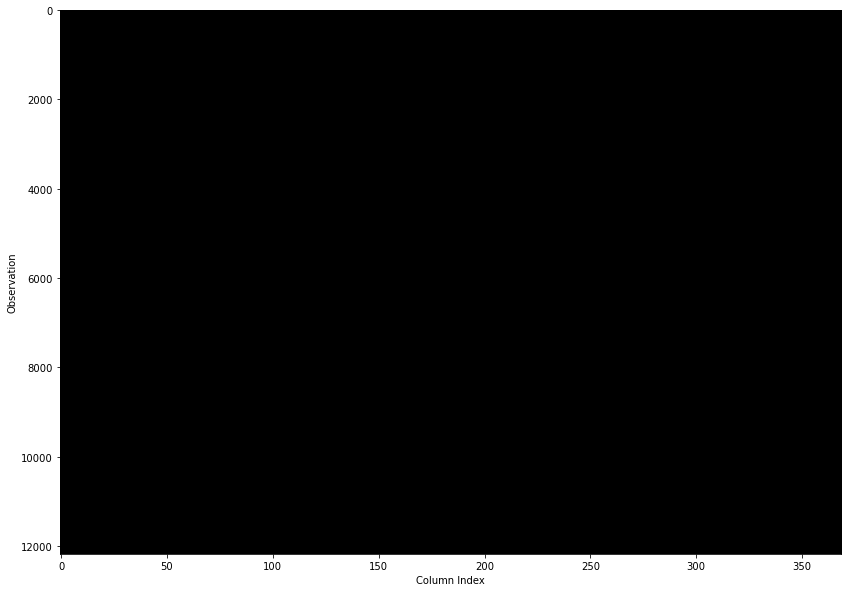

In [13]:
test_df = data.merge(searches, on=['state', 'date'], how='left')

fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(test_df.isna(), aspect="auto", interpolation="nearest", cmap="gray")

ax.set_xlabel("Column Index")
ax.set_ylabel("Observation")

In [17]:
correlation = test_df.corr()
diag_mask = np.triu(np.ones_like(correlation, dtype=bool))
colors = sns.diverging_palette(230, 20, as_cmap=True)

<AxesSubplot:>

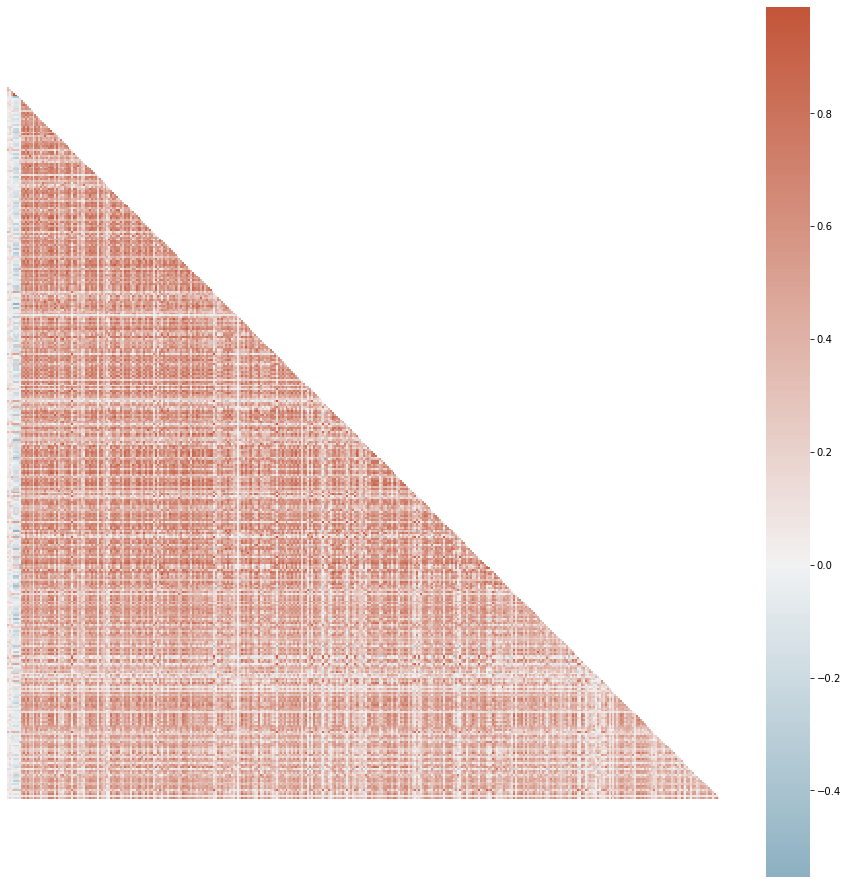

In [18]:
colors = sns.diverging_palette(230, 20, as_cmap=True)
plt.subplots(figsize=(16,16))
sns.heatmap(correlation, mask=diag_mask, center=0, square=True, cmap=colors,
           xticklabels = False, yticklabels = False)

Well, it's certainly true that the search data is highly correlated with itself. However, the correlations on the first four columns (i.e. with cases, deaths, and vaccinations) is nearly impossible to read. Let's take a closer look at it...

(As an aside, we would not expect any symptoms to be *negatively* correlated with case rates, so we are only interested in positive correlations).

In [19]:
correlation[correlation['cases'] > 0.10]['cases'].sort_values()

symptom:Stroke             0.100231
symptom:Eye strain         0.101608
symptom:Indigestion        0.102154
symptom:Tenderness         0.102551
symptom:Angioedema         0.103821
                             ...   
symptom:Chills             0.390512
total_distributed          0.397496
symptom:Fever              0.401799
symptom:Low-grade fever    0.417697
cases                      1.000000
Name: cases, Length: 76, dtype: float64

### Feature Selection and Assessment

In [20]:
# I'm going to make a list of features which correlate with the number of cases by more than 0.1. I will
# keep these columns for the later analysis.

keep_cols = list(correlation[correlation['cases'] > 0.10]['cases'].sort_values().index)
keep_cols.append("state")
keep_cols.append('date')
len(keep_cols)

78

In [21]:
test_df_cut = test_df[keep_cols]
test_df_cut = test_df_cut.set_index(['state', 'date', "cases"]).reset_index()
test_df_cut

,state,date,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,...,symptom:Common cold,symptom:Phlegm,symptom:Pneumonia,symptom:Shivering,symptom:Sputum,symptom:Hypoxemia,symptom:Chills,total_distributed,symptom:Fever,symptom:Low-grade fever
0,Alabama,2021-01-12,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,...,9.75,0.63,1.67,0.26,0.20,0.70,0.31,377025.0,3.88,0.28
1,Alabama,2021-01-13,3147,2.71,0.26,1.57,0.15,0.18,0.25,0.37,...,9.62,0.57,1.56,0.23,0.17,0.73,0.34,378975.0,3.92,0.27
2,Alabama,2021-01-14,3588,2.64,0.31,1.66,0.15,0.18,0.21,0.41,...,9.36,0.59,1.63,0.21,0.15,0.76,0.31,435350.0,4.06,0.28
3,Alabama,2021-01-15,2945,2.52,0.27,1.55,0.16,0.15,0.19,0.36,...,9.17,0.64,1.59,0.21,0.16,0.71,0.30,444650.0,3.81,0.27
4,Alabama,2021-01-16,3153,2.30,0.27,1.67,0.14,0.24,0.20,0.38,...,9.73,0.65,1.28,0.26,0.14,0.73,0.30,444650.0,3.78,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12175,Wisconsin,2022-03-03,576,2.69,0.23,1.30,0.15,0.23,0.10,0.27,...,8.38,0.63,1.05,0.19,0.17,0.24,0.25,11106345.0,2.89,0.14
12176,Wisconsin,2022-03-04,542,2.46,0.20,1.28,0.11,0.20,0.11,0.26,...,7.90,0.55,0.94,0.17,0.15,0.25,0.24,11114045.0,2.80,0.09
12177,Wisconsin,2022-03-05,0,2.06,0.17,1.49,0.12,0.18,0.11,0.29,...,8.50,0.63,0.85,0.18,0.12,0.24,0.22,11118845.0,2.93,0.15
12178,Wisconsin,2022-03-06,0,2.09,0.16,1.58,0.13,0.18,0.11,0.25,...,8.73,0.66,0.93,0.20,0.15,0.25,0.26,11118845.0,2.98,0.13


In [22]:
test_df_cut['state'].unique()

array(['Alabama', 'Arizona', 'California', 'Colorado', 'Connecticut',
       'Florida', 'Georgia', 'Indiana', 'Kentucky', 'Louisiana',
       'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Missouri',
       'Nevada', 'New Jersey', 'North Carolina', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'South Carolina', 'Tennessee', 'Texas',
       'Utah', 'Virginia', 'Washington', 'Wisconsin'], dtype=object)

In [23]:
test_df_cut.to_csv("COVID19_cases_searches_naiveLR.csv", index=False)

To validate my approach, I'm going to plot the case rate for a few states against one of the correlated symptoms to see if there may be any predictive value in our symptom data.

In [374]:
graph = test_df_cut[test_df_cut['state'].isin(['Wisconsin', 'Alabama', 'California', 'Tennessee'])]
graph = graph[['state', 'date', 'cases', 'symptom:Low-grade fever']]
graph['date'] = pd.to_datetime(graph['date']).dt.date
graph

,state,date,cases,symptom:Low-grade fever
0,Alabama,2021-01-12,3848,0.28
1,Alabama,2021-01-13,3147,0.27
2,Alabama,2021-01-14,3588,0.28
3,Alabama,2021-01-15,2945,0.27
4,Alabama,2021-01-16,3153,0.26
...,...,...,...,...
12175,Wisconsin,2022-03-03,576,0.14
12176,Wisconsin,2022-03-04,542,0.09
12177,Wisconsin,2022-03-05,0,0.15
12178,Wisconsin,2022-03-06,0,0.13


This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


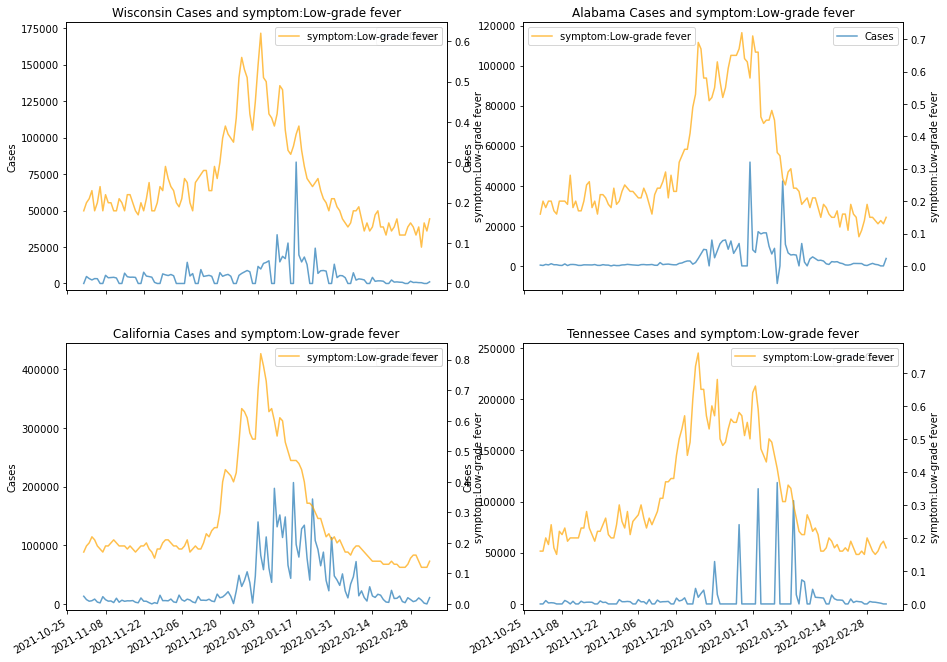

In [376]:
states = ['Wisconsin', 'Alabama', 'California', 'Tennessee']

fig, axs = plt.subplots(2, 2, figsize = (15,12), constrained_layout=True)

for i, ax in enumerate(axs.reshape(-1)):
    grapher_byState(ax, test_df, states[i], ['cases', 'symptom:Low-grade fever'], ["Cases", "symptom:Low-grade fever"], dates=['2021-10-30', '2022-04-01'])

There are a few key observations here:
1. Peaks in the symptom "Low-grade fever" are followed by peaks in the number of cases, suggesting that people are searching their symptoms before cases are reported by the state. At first, I believed that this could be the testing delay, but given that each tick is 14 days, I would be very surprised if there were a week-long delay between testing and reporting results at this stage of the pandemic (this date slice is during Omicron's peak). I believe that people are searching their symptoms before deciding to get tested.
2. There is some clear periodicity in the reporting of cases. It seems like the periods are weekly, suggesting that different states are biased toward reporting their cases on different days of the week. We may need to smooth daily case values to reduce the variability in reporting based on day of the week.

Let's look at the general distribution of a subset of features in a subset of our states.

In [65]:
### subsetting features and states randomly
test_df_cut2 = test_df_cut.copy()
state_subset = random.sample(list(test_df_cut2['state'].unique()), 10)
test_df_cut2 = test_df_cut2[test_df_cut2['state'].isin(state_subset)]
test_df_cut2 = test_df_cut2.sample(frac=0.2)

22.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
6.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
12.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


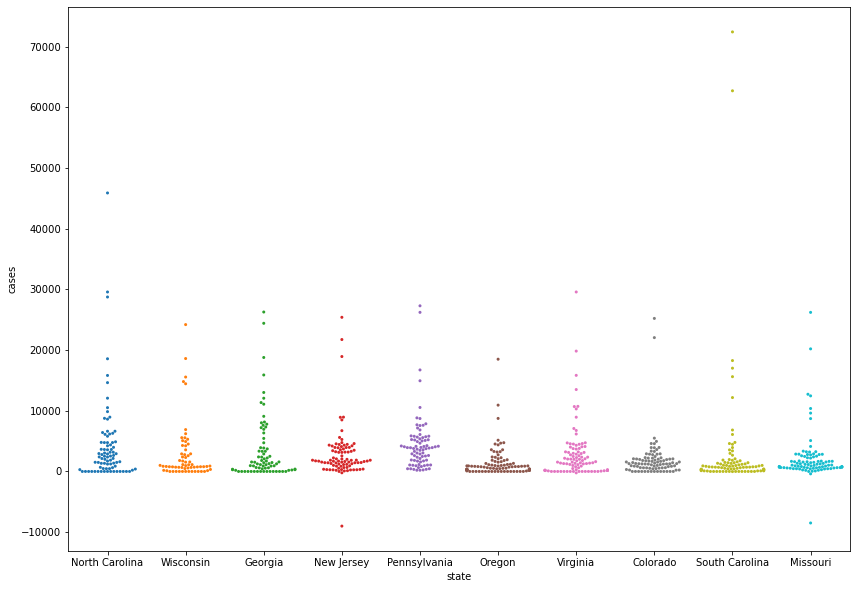

In [71]:
fig, ax = plt.subplots(figsize=(14, 10))
ax = sns.swarmplot(x = 'state', y = 'cases', data = test_df_cut2, ax = ax, size = 3)

The distribution of cases is right-skewed. As you can see, the vast majority of observations for 'cases' are near or at 0. During COVID, I doubt there were any days where there were truly 0 cases, so I suspect this is an data artefact as each state may dump positive tests into their database on particular days.

In [74]:
test_df_cut2.describe()

,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,symptom:Pleural effusion,symptom:Delayed onset muscle soreness,...,symptom:Common cold,symptom:Phlegm,symptom:Pneumonia,symptom:Shivering,symptom:Sputum,symptom:Hypoxemia,symptom:Chills,total_distributed,symptom:Fever,symptom:Low-grade fever
count,840.000000,840.00000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,...,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,8.400000e+02,840.000000,840.000000
mean,2989.039286,2.47300,0.231036,1.393821,0.130226,0.181881,0.131298,0.320595,0.213083,0.453298,...,9.029060,0.654155,1.108869,0.189393,0.152750,0.383905,0.265333,9.448612e+06,3.619488,0.211517
std,5623.795533,0.49558,0.048014,0.221672,0.023745,0.033107,0.032237,0.052382,0.052993,0.075913,...,3.431025,0.230253,0.415728,0.047969,0.046313,0.134371,0.086009,6.017737e+06,1.046731,0.113554
min,-9005.000000,1.27000,0.120000,0.850000,0.040000,0.100000,0.050000,0.180000,0.070000,0.210000,...,3.730000,0.230000,0.390000,0.070000,0.050000,0.140000,0.110000,3.350750e+05,1.890000,0.070000
25%,434.000000,2.14000,0.200000,1.280000,0.120000,0.160000,0.110000,0.290000,0.170000,0.400000,...,6.937500,0.510000,0.830000,0.160000,0.120000,0.290000,0.220000,5.208485e+06,3.040000,0.150000
50%,1359.500000,2.50000,0.220000,1.395000,0.130000,0.180000,0.130000,0.320000,0.210000,0.460000,...,8.280000,0.620000,1.020000,0.185000,0.140000,0.360000,0.250000,8.800865e+06,3.450000,0.190000
75%,3347.000000,2.73000,0.250000,1.510000,0.140000,0.200000,0.150000,0.350000,0.250000,0.500000,...,10.152500,0.740000,1.280000,0.210000,0.170000,0.450000,0.290000,1.293820e+07,3.840000,0.220000
max,72445.000000,6.75000,0.500000,2.170000,0.230000,0.350000,0.290000,0.500000,0.400000,0.760000,...,28.150000,1.840000,2.950000,0.460000,0.380000,0.970000,0.850000,2.898322e+07,10.390000,1.030000


Next, let's determine through ols linear regression whether any particular symptoms are linearly correlated with case rates.

### Smoothing Cases

We're going to use rolling average to smooth over the cases. The true cases probably aren't 'peaking' in the same way described in our time chart; it is simply a data artifact due to how states report. Because the periodicity appears to be weekly, let's set the "span" to 7 days.

In [377]:
df = pd.read_csv("COVID19_cases_searches_naiveLR.csv")
df.head()

,state,date,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,symptom:Middle back pain,...,symptom:Common cold,symptom:Phlegm,symptom:Pneumonia,symptom:Shivering,symptom:Sputum,symptom:Hypoxemia,symptom:Chills,total_distributed,symptom:Fever,symptom:Low-grade fever
0,Alabama,2021-01-12,3848,2.60,0.29,1.52,0.11,0.18,0.20,0.38,...,9.75,0.63,1.67,0.26,0.20,0.70,0.31,377025.0,3.88,0.28
1,Alabama,2021-01-13,3147,2.71,0.26,1.57,0.15,0.18,0.25,0.37,...,9.62,0.57,1.56,0.23,0.17,0.73,0.34,378975.0,3.92,0.27
2,Alabama,2021-01-14,3588,2.64,0.31,1.66,0.15,0.18,0.21,0.41,...,9.36,0.59,1.63,0.21,0.15,0.76,0.31,435350.0,4.06,0.28
3,Alabama,2021-01-15,2945,2.52,0.27,1.55,0.16,0.15,0.19,0.36,...,9.17,0.64,1.59,0.21,0.16,0.71,0.30,444650.0,3.81,0.27
4,Alabama,2021-01-16,3153,2.30,0.27,1.67,0.14,0.24,0.20,0.38,...,9.73,0.65,1.28,0.26,0.14,0.73,0.30,444650.0,3.78,0.26


In [378]:
df2 = pd.DataFrame(columns=df.columns)

for state in df['state'].unique():
    state_df = df[df['state'] == state]
    state_df['cases_7ewm'] = state_df['cases'].rolling(window=7, min_periods=1).mean()
    df2 = pd.concat([df2, state_df], axis=0)

df2 = df2.set_index(['state', 'date', 'cases', 'cases_7ewm']).reset_index()
df = df2.copy()
del df2
df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,state,date,cases,cases_7ewm,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,...,symptom:Common cold,symptom:Phlegm,symptom:Pneumonia,symptom:Shivering,symptom:Sputum,symptom:Hypoxemia,symptom:Chills,total_distributed,symptom:Fever,symptom:Low-grade fever
0,Alabama,2021-01-12,3848,3848.000000,2.60,0.29,1.52,0.11,0.18,0.20,...,9.75,0.63,1.67,0.26,0.20,0.70,0.31,377025.0,3.88,0.28
1,Alabama,2021-01-13,3147,3497.500000,2.71,0.26,1.57,0.15,0.18,0.25,...,9.62,0.57,1.56,0.23,0.17,0.73,0.34,378975.0,3.92,0.27
2,Alabama,2021-01-14,3588,3527.666667,2.64,0.31,1.66,0.15,0.18,0.21,...,9.36,0.59,1.63,0.21,0.15,0.76,0.31,435350.0,4.06,0.28
3,Alabama,2021-01-15,2945,3382.000000,2.52,0.27,1.55,0.16,0.15,0.19,...,9.17,0.64,1.59,0.21,0.16,0.71,0.30,444650.0,3.81,0.27
4,Alabama,2021-01-16,3153,3336.200000,2.30,0.27,1.67,0.14,0.24,0.20,...,9.73,0.65,1.28,0.26,0.14,0.73,0.30,444650.0,3.78,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12175,Wisconsin,2022-03-03,576,623.714286,2.69,0.23,1.30,0.15,0.23,0.10,...,8.38,0.63,1.05,0.19,0.17,0.24,0.25,11106345.0,2.89,0.14
12176,Wisconsin,2022-03-04,542,588.714286,2.46,0.20,1.28,0.11,0.20,0.11,...,7.90,0.55,0.94,0.17,0.15,0.25,0.24,11114045.0,2.80,0.09
12177,Wisconsin,2022-03-05,0,588.714286,2.06,0.17,1.49,0.12,0.18,0.11,...,8.50,0.63,0.85,0.18,0.12,0.24,0.22,11118845.0,2.93,0.15
12178,Wisconsin,2022-03-06,0,588.714286,2.09,0.16,1.58,0.13,0.18,0.11,...,8.73,0.66,0.93,0.20,0.15,0.25,0.26,11118845.0,2.98,0.13


This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


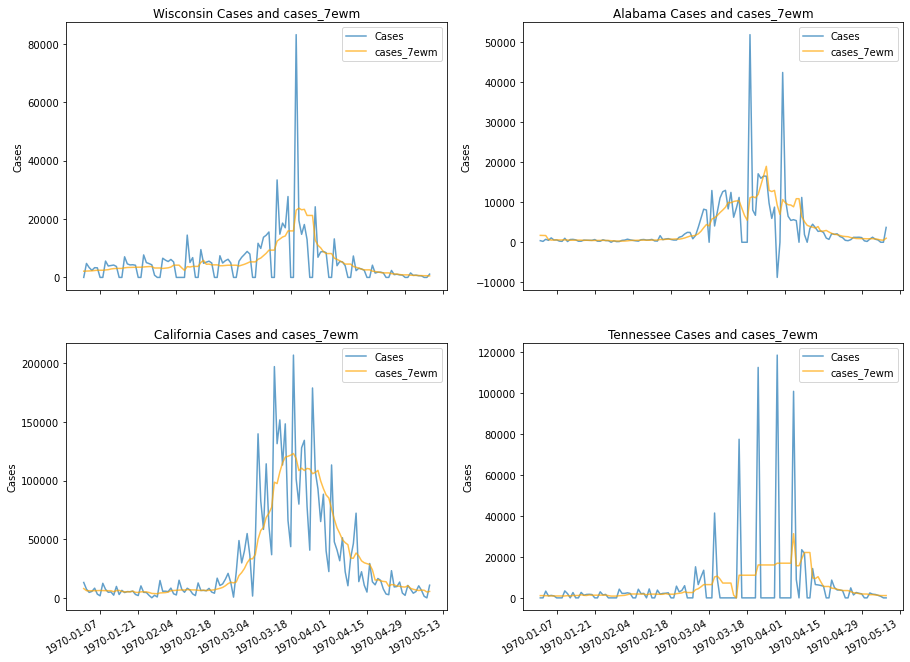

In [380]:
states = ['Wisconsin', 'Alabama', 'California', 'Tennessee']

fig, axs = plt.subplots(2, 2, figsize = (15,12), constrained_layout=True)

for i, ax in enumerate(axs.reshape(-1)):
    grapher_byState_sameAxis(ax, df, states[i], ['cases', 'cases_7ewm'], ["Cases", 'cases_7ewm'], dates=['2021-10-30', '2022-04-01'])

Looks great!

In [381]:
df.to_csv("COVID19_cases_searches_naiveLR.csv", index=False)

### Adding other features to predict: cases after 1, 7, and 14 days

I'd like to add columns for the cases after 1, 3, and 5 days to see whether any of our features correlate with them.

In [383]:
test_df_cut = pd.read_csv("COVID19_cases_searches_naiveLR.csv", parse_dates=['date'])
test_df_cut.head()

,state,date,cases,cases_7ewm,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,...,symptom:Common cold,symptom:Phlegm,symptom:Pneumonia,symptom:Shivering,symptom:Sputum,symptom:Hypoxemia,symptom:Chills,total_distributed,symptom:Fever,symptom:Low-grade fever
0,Alabama,2021-01-12,3848,3848.000000,2.60,0.29,1.52,0.11,0.18,0.20,...,9.75,0.63,1.67,0.26,0.20,0.70,0.31,377025.0,3.88,0.28
1,Alabama,2021-01-13,3147,3497.500000,2.71,0.26,1.57,0.15,0.18,0.25,...,9.62,0.57,1.56,0.23,0.17,0.73,0.34,378975.0,3.92,0.27
2,Alabama,2021-01-14,3588,3527.666667,2.64,0.31,1.66,0.15,0.18,0.21,...,9.36,0.59,1.63,0.21,0.15,0.76,0.31,435350.0,4.06,0.28
3,Alabama,2021-01-15,2945,3382.000000,2.52,0.27,1.55,0.16,0.15,0.19,...,9.17,0.64,1.59,0.21,0.16,0.71,0.30,444650.0,3.81,0.27
4,Alabama,2021-01-16,3153,3336.200000,2.30,0.27,1.67,0.14,0.24,0.20,...,9.73,0.65,1.28,0.26,0.14,0.73,0.30,444650.0,3.78,0.26


In [384]:
df = test_df_cut.copy()

In [385]:
df['day1'] = df['date'] + timedelta(days=1)
df['day7'] = df['date'] + timedelta(days=7)
df['day14'] = df['date'] + timedelta(days=14)

In [386]:
df['day1_cases'] = -9999
df['day7_cases'] = -9999
df['day14_cases'] = -9999

In [387]:
for i in range(0, df.shape[0]):
    state = df.state[i]
    day1 = str(df.loc[i,'day1'].date())
    day7 = str(df.loc[i, 'day7'].date())
    day14 = str(df.loc[i, 'day14'].date())

    
    try:
        day1_cases = df[(df['date'] == day1)
                        & (df['state'] == state)]['cases_7ewm'].values[0]
        df['day1_cases'][i] = day1_cases
    except:
        df['day1_cases'][i] = -9999
        
    try:
        day7_cases = df[(df['date'] == day7)
                        & (df['state'] == state)]['cases_7ewm'].values[0]
        df['day7_cases'][i] = day7_cases
    except:
        df['day7_cases'][i] = -9999
        
    try:
        day14_cases = df[(df['date'] == day14)
                        & (df['state'] == state)]['cases_7ewm'].values[0]
        df['day14_cases'][i] = day14_cases
    except:
        df['day14_cases'][i] = -9999
        

df.head()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

,state,date,cases,cases_7ewm,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,symptom:Tenderness,symptom:Angioedema,symptom:Pleurisy,...,symptom:Chills,total_distributed,symptom:Fever,symptom:Low-grade fever,day1,day7,day14,day1_cases,day7_cases,day14_cases
0,Alabama,2021-01-12,3848,3848.000000,2.60,0.29,1.52,0.11,0.18,0.20,...,0.31,377025.0,3.88,0.28,2021-01-13,2021-01-19,2021-01-26,3497,2670,2766
1,Alabama,2021-01-13,3147,3497.500000,2.71,0.26,1.57,0.15,0.18,0.25,...,0.34,378975.0,3.92,0.27,2021-01-14,2021-01-20,2021-01-27,3527,2665,2775
2,Alabama,2021-01-14,3588,3527.666667,2.64,0.31,1.66,0.15,0.18,0.21,...,0.31,435350.0,4.06,0.28,2021-01-15,2021-01-21,2021-01-28,3382,2564,2885
3,Alabama,2021-01-15,2945,3382.000000,2.52,0.27,1.55,0.16,0.15,0.19,...,0.30,444650.0,3.81,0.27,2021-01-16,2021-01-22,2021-01-29,3336,2651,2785
4,Alabama,2021-01-16,3153,3336.200000,2.30,0.27,1.67,0.14,0.24,0.20,...,0.30,444650.0,3.78,0.26,2021-01-17,2021-01-23,2021-01-30,3099,2680,2305


In [388]:
df = df.drop(['day1', 'day7', 'day14'], axis=1).set_index(['state','date','cases_7ewm','day1_cases','day7_cases','day14_cases']).reset_index()
df.head()

,state,date,cases_7ewm,day1_cases,day7_cases,day14_cases,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,...,symptom:Common cold,symptom:Phlegm,symptom:Pneumonia,symptom:Shivering,symptom:Sputum,symptom:Hypoxemia,symptom:Chills,total_distributed,symptom:Fever,symptom:Low-grade fever
0,Alabama,2021-01-12,3848.000000,3497,2670,2766,3848,2.60,0.29,1.52,...,9.75,0.63,1.67,0.26,0.20,0.70,0.31,377025.0,3.88,0.28
1,Alabama,2021-01-13,3497.500000,3527,2665,2775,3147,2.71,0.26,1.57,...,9.62,0.57,1.56,0.23,0.17,0.73,0.34,378975.0,3.92,0.27
2,Alabama,2021-01-14,3527.666667,3382,2564,2885,3588,2.64,0.31,1.66,...,9.36,0.59,1.63,0.21,0.15,0.76,0.31,435350.0,4.06,0.28
3,Alabama,2021-01-15,3382.000000,3336,2651,2785,2945,2.52,0.27,1.55,...,9.17,0.64,1.59,0.21,0.16,0.71,0.30,444650.0,3.81,0.27
4,Alabama,2021-01-16,3336.200000,3099,2680,2305,3153,2.30,0.27,1.67,...,9.73,0.65,1.28,0.26,0.14,0.73,0.30,444650.0,3.78,0.26


In [389]:
#### Since I filled "junk" values with -9999 to prevent errors, I would like to now refill them with np.nan
df = df.replace(-9999, np.nan)

In [390]:
df.to_csv("symptoms_cases_day1_7_14.csv", index=False)

## Basic Linear Regression Using Individual Features

As shown previously, our symptom search trends are highly correlated, confounding the interpretation of marginal effects on multiple linear regressions. For now, we will perform a linear regression using each symptom individually as a predictor, then perform a FDR correction to find significantly correlated symptoms.

Since I am only making interpretation of existing data and not trying to make a predictive model, I will not perform a test-train split.

In [391]:
df = pd.read_csv("symptoms_cases_day1_7_14.csv", parse_dates=['date'])
df = df.set_index(['date'], drop=True).reset_index()
df.head()

,date,state,cases_7ewm,day1_cases,day7_cases,day14_cases,cases,symptom:Stroke,symptom:Eye strain,symptom:Indigestion,...,symptom:Common cold,symptom:Phlegm,symptom:Pneumonia,symptom:Shivering,symptom:Sputum,symptom:Hypoxemia,symptom:Chills,total_distributed,symptom:Fever,symptom:Low-grade fever
0,2021-01-12,Alabama,3848.000000,3497.0,2670.0,2766.0,3848,2.60,0.29,1.52,...,9.75,0.63,1.67,0.26,0.20,0.70,0.31,377025.0,3.88,0.28
1,2021-01-13,Alabama,3497.500000,3527.0,2665.0,2775.0,3147,2.71,0.26,1.57,...,9.62,0.57,1.56,0.23,0.17,0.73,0.34,378975.0,3.92,0.27
2,2021-01-14,Alabama,3527.666667,3382.0,2564.0,2885.0,3588,2.64,0.31,1.66,...,9.36,0.59,1.63,0.21,0.15,0.76,0.31,435350.0,4.06,0.28
3,2021-01-15,Alabama,3382.000000,3336.0,2651.0,2785.0,2945,2.52,0.27,1.55,...,9.17,0.64,1.59,0.21,0.16,0.71,0.30,444650.0,3.81,0.27
4,2021-01-16,Alabama,3336.200000,3099.0,2680.0,2305.0,3153,2.30,0.27,1.67,...,9.73,0.65,1.28,0.26,0.14,0.73,0.30,444650.0,3.78,0.26


In [392]:
cols = [col.replace(":", "_").replace(" ","_").replace("-","_") for col in df.columns]
df.columns = cols
df.head()

,date,state,cases_7ewm,day1_cases,day7_cases,day14_cases,cases,symptom_Stroke,symptom_Eye_strain,symptom_Indigestion,...,symptom_Common_cold,symptom_Phlegm,symptom_Pneumonia,symptom_Shivering,symptom_Sputum,symptom_Hypoxemia,symptom_Chills,total_distributed,symptom_Fever,symptom_Low_grade_fever
0,2021-01-12,Alabama,3848.000000,3497.0,2670.0,2766.0,3848,2.60,0.29,1.52,...,9.75,0.63,1.67,0.26,0.20,0.70,0.31,377025.0,3.88,0.28
1,2021-01-13,Alabama,3497.500000,3527.0,2665.0,2775.0,3147,2.71,0.26,1.57,...,9.62,0.57,1.56,0.23,0.17,0.73,0.34,378975.0,3.92,0.27
2,2021-01-14,Alabama,3527.666667,3382.0,2564.0,2885.0,3588,2.64,0.31,1.66,...,9.36,0.59,1.63,0.21,0.15,0.76,0.31,435350.0,4.06,0.28
3,2021-01-15,Alabama,3382.000000,3336.0,2651.0,2785.0,2945,2.52,0.27,1.55,...,9.17,0.64,1.59,0.21,0.16,0.71,0.30,444650.0,3.81,0.27
4,2021-01-16,Alabama,3336.200000,3099.0,2680.0,2305.0,3153,2.30,0.27,1.67,...,9.73,0.65,1.28,0.26,0.14,0.73,0.30,444650.0,3.78,0.26


### Scaling Features

To make the coefficients comparable, I'm going to scale each of the symptoms from 0 to 1.

In [394]:
scaler = MinMaxScaler()

cases = df[[col for col in df.columns if not 'symptom' in col]]
nonsympt = [col for col in df.columns if not 'symptom' in col]
columns = [col for col in df.columns if 'symptom' in col]

df2 = pd.DataFrame(scaler.fit_transform(df.drop(nonsympt, axis=1)))
df2.columns = columns

df3 = cases.merge(df2, how='left', left_index=True, right_index=True)
df3

df = df3.copy()
del df3
del df2
df

,date,state,cases_7ewm,day1_cases,day7_cases,day14_cases,cases,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,distributed_per_hundred,...,symptom_Cough,symptom_Common_cold,symptom_Phlegm,symptom_Pneumonia,symptom_Shivering,symptom_Sputum,symptom_Hypoxemia,symptom_Chills,symptom_Fever,symptom_Low_grade_fever
0,2021-01-12,Alabama,3848.000000,3497.0,2670.0,2766.0,3848,0.1500,1.590,7.69,...,0.253875,0.248366,0.252874,0.459184,0.476190,0.394737,0.591837,0.298701,0.217161,0.209091
1,2021-01-13,Alabama,3497.500000,3527.0,2665.0,2775.0,3147,0.1900,1.710,7.73,...,0.245018,0.243056,0.218391,0.421769,0.404762,0.315789,0.622449,0.337662,0.221398,0.200000
2,2021-01-14,Alabama,3527.666667,3382.0,2564.0,2885.0,3588,0.2350,1.880,8.88,...,0.245018,0.232435,0.229885,0.445578,0.357143,0.263158,0.653061,0.298701,0.236229,0.209091
3,2021-01-15,Alabama,3382.000000,3336.0,2651.0,2785.0,2945,0.2800,2.050,9.07,...,0.238376,0.224673,0.258621,0.431973,0.357143,0.289474,0.602041,0.285714,0.209746,0.200000
4,2021-01-16,Alabama,3336.200000,3099.0,2680.0,2305.0,3153,0.2925,2.205,9.07,...,0.244280,0.247549,0.264368,0.326531,0.476190,0.236842,0.622449,0.285714,0.206568,0.190909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12175,2022-03-03,Wisconsin,623.714286,588.0,NaN,NaN,576,64.6600,169.700,190.75,...,0.211808,0.192402,0.252874,0.248299,0.309524,0.315789,0.122449,0.220779,0.112288,0.081818
12176,2022-03-04,Wisconsin,588.714286,588.0,NaN,NaN,542,64.6900,169.810,190.88,...,0.194834,0.172794,0.206897,0.210884,0.261905,0.263158,0.132653,0.207792,0.102754,0.036364
12177,2022-03-05,Wisconsin,588.714286,588.0,NaN,NaN,0,64.7100,169.900,190.97,...,0.197786,0.197304,0.252874,0.180272,0.285714,0.184211,0.122449,0.181818,0.116525,0.090909
12178,2022-03-06,Wisconsin,588.714286,530.0,NaN,NaN,0,64.7400,169.990,190.97,...,0.223616,0.206699,0.270115,0.207483,0.333333,0.263158,0.132653,0.233766,0.121822,0.072727


In [395]:
df.to_csv("symptoms_cases_day1_7_14_scaled2.csv", index=False)

### Simple (Univariate) Linear Models

Finally, let's make a simple linear model with each symptom as an individual predictor.

Why make only a univariate model? From our previous correlation plot, we know that our symptom features are highly correlated with each other. Multiple linear regression struggles to output interpretable coefficients with high multicollinearity, and at this point I'm only interested to see whether there is a statistically significant relationship between any individual symptoms and the number of cases. So, for now, we will create many univariate models and then correct the p-values using the Benjamini-Hochberg correction.

In [398]:
symptoms = [col for col in df.columns if 'symptom' in col]

result_df = []

for sym in symptoms:
    results = [sym]
    formula = "cases_7ewm ~ " + sym
    mod = smf.ols(formula = formula, data = df)
    res = mod.fit()
    coef = list(res.params)     # coefficients for regression
    pval = res.pvalues[1]  # P value for predictor
    results = results + coef
    results.append(pval)
    result_df.append(results)

result_df = pd.DataFrame(result_df)
result_df.columns = ['symptom', 'intercept', 'coef', 'pval']
result_df = result_df.sort_values('pval', ascending=True).reset_index(drop=True)
result_df['FDR'] = np.vectorize(FDR_correction)(result_df['pval'], result_df.index + 1, 70)
result_df

,symptom,intercept,coef,pval,FDR
0,symptom_Low_grade_fever,-1353.753951,33530.663987,0.000000e+00,0.000000e+00
1,symptom_Fever,-2201.454425,29368.081469,0.000000e+00,0.000000e+00
2,symptom_Throat_irritation,-1655.617998,22346.809160,0.000000e+00,0.000000e+00
3,symptom_Sore_throat,-1191.650250,19234.178117,0.000000e+00,0.000000e+00
4,symptom_Cough,-1131.042167,19871.925225,0.000000e+00,0.000000e+00
...,...,...,...,...,...
65,symptom_Periodontal_disease,1064.464046,6339.962766,7.986939e-32,8.470996e-32
66,symptom_Migraine,968.592987,5650.336895,8.131465e-32,8.495560e-32
67,symptom_Visual_acuity,1701.925452,8247.853620,4.565641e-28,4.699925e-28
68,symptom_Pleural_effusion,1738.592763,5707.851059,3.786052e-20,3.840923e-20


So every single symptom is significant at alpha = 0.01. I am not too surprised because we have thousands of data points, so the chance that the true slope will not be zero at statistical significance is quite high, even if the slope itself is marginal. Furthermore, any test correction will still output a larger number of false positives because our symptoms are highly correlated. 

Again, since these symptoms are highly correlated, the marginal coefficients of a multiple linear regression would be misleading. So, I will instead remove the multicollinearity by PCA and then perform multiple linear regression.

## Multiple Linear Regression on PCA Dimensions: Predicting Cases after 1 Week

If I wanted a more interpretable model, I may have instead used a simple linear model, calculated the eigenvalues, and then train another linear model with L2 regularization (setting the omega value based on the smallest eigenvalues). However, this project requires the use of only a simple linear or logistic regression. So, I will instead remove the collinearity via PCA and perform a multiple linear regression on the axes.

In [399]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [400]:
df = pd.read_csv("symptoms_cases_day1_7_14_scaled2.csv", parse_dates=['date'])

In [401]:
symptoms = [col for col in df.columns if 'symptom' in col]
nonsympt = [col for col in df.columns if not 'symptom' in col]
sympt = df[symptoms]
cases = df[nonsympt]

In [402]:
pipe = make_pipeline(StandardScaler(), PCA(n_components = 0.95))

PCA_df = pd.DataFrame(pipe.fit_transform(sympt))
newcols = ['PCA' + str(i+1) for i in range(0, PCA_df.shape[1])]
PCA_df.columns = newcols
PCA_df = cases.merge(PCA_df, how='left', right_index=True, left_index=True)
PCA_df

,date,state,cases_7ewm,day1_cases,day7_cases,day14_cases,cases,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,distributed_per_hundred,...,PCA21,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30
0,2021-01-12,Alabama,3848.000000,3497.0,2670.0,2766.0,3848,0.1500,1.590,7.69,...,-0.001299,-1.051108,0.049442,0.036445,-0.097427,0.222102,0.523276,-0.791568,0.258096,0.103992
1,2021-01-13,Alabama,3497.500000,3527.0,2665.0,2775.0,3147,0.1900,1.710,7.73,...,0.010227,0.429056,-0.629275,0.964807,0.045447,-0.661486,-0.071350,-0.569590,-0.162728,0.406475
2,2021-01-14,Alabama,3527.666667,3382.0,2564.0,2885.0,3588,0.2350,1.880,8.88,...,0.276096,-0.436407,-1.177230,0.018171,0.233678,-0.220097,0.040736,0.034506,0.068239,0.297959
3,2021-01-15,Alabama,3382.000000,3336.0,2651.0,2785.0,2945,0.2800,2.050,9.07,...,-0.709200,0.125867,-0.227742,0.812035,0.230564,-0.779614,0.563964,-0.511651,0.470560,-0.216325
4,2021-01-16,Alabama,3336.200000,3099.0,2680.0,2305.0,3153,0.2925,2.205,9.07,...,0.403009,-0.109861,-1.694135,0.581554,0.551766,-0.000366,-0.485989,-0.807529,0.599322,-0.147424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12175,2022-03-03,Wisconsin,623.714286,588.0,NaN,NaN,576,64.6600,169.700,190.75,...,-0.960920,0.653898,0.061195,-0.087135,-0.099779,0.142119,-0.091319,0.049824,-0.114583,0.715042
12176,2022-03-04,Wisconsin,588.714286,588.0,NaN,NaN,542,64.6900,169.810,190.88,...,-1.089251,0.575490,0.340593,0.069552,-0.470579,0.070150,-0.816361,-0.323305,-0.027715,0.345261
12177,2022-03-05,Wisconsin,588.714286,588.0,NaN,NaN,0,64.7100,169.900,190.97,...,-1.084505,-0.407090,0.864673,-0.521749,-0.127799,-0.057630,-0.094009,-0.475943,-0.008574,0.271340
12178,2022-03-06,Wisconsin,588.714286,530.0,NaN,NaN,0,64.7400,169.990,190.97,...,-0.388543,0.611086,-0.523098,-0.233188,-0.220573,-0.121253,0.259027,-0.832088,-0.820063,0.051480


In [403]:
### Also, let's scale 'today's cases' to thousands of cases to make the output values from our later linear regressions more interpretable.

PCA_df['cases_7ewm_inThousands'] = PCA_df['cases_7ewm'] / 1000

In [404]:
PCA_df.to_csv("symptoms_cases_day1_7_14_scaled3.csv", index=False)

In [405]:
## Also saving components for later use.

PCA_components = pd.DataFrame(pipe['pca'].components_)
PCA_components.columns = symptoms
PCA_components = PCA_components.T
PCA_components.columns = ['PCA' + str(i) for i in range(1,31)]
PCA_components.to_csv("PCA_components.csv")

Let's quickly look at which PCA dimensions correlate with case values (if any).

In [406]:
correlation = PCA_df.corr()
diag_mask = np.triu(np.ones_like(correlation, dtype=bool))
colors = sns.diverging_palette(230, 20, as_cmap=True)

<AxesSubplot:>

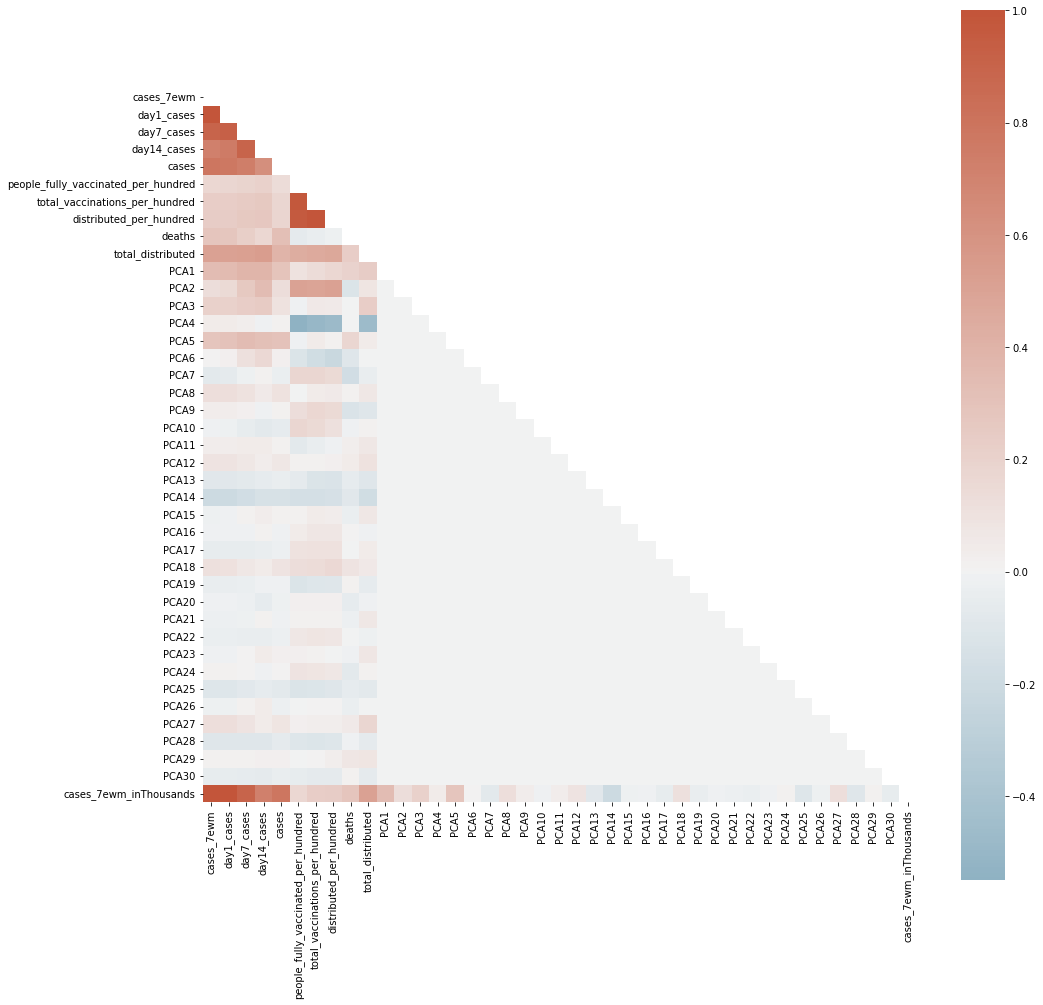

In [407]:
plt.subplots(figsize=(16,16))
sns.heatmap(correlation, mask=diag_mask, center=0, square=True, cmap=colors)

In [408]:
correlation[(correlation['cases_7ewm'].abs() > 0.1) & (correlation['day1_cases'].abs() > 0.2)]

,cases_7ewm,day1_cases,day7_cases,day14_cases,cases,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,distributed_per_hundred,deaths,total_distributed,...,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30,cases_7ewm_inThousands
cases_7ewm,1.000000,0.991983,0.902988,0.715973,0.782508,0.170168,0.225667,0.239602,0.290295,0.509923,...,-3.106517e-02,-7.688764e-03,7.859605e-03,-1.060066e-01,-2.168553e-02,1.266125e-01,-9.635932e-02,1.625743e-02,-4.835220e-02,1.000000
day1_cases,0.991983,1.000000,0.926347,0.746250,0.776701,0.173475,0.228652,0.242211,0.278015,0.511481,...,-3.307208e-02,-7.244483e-03,1.076267e-02,-1.040075e-01,-1.924149e-02,1.240372e-01,-9.553351e-02,1.470165e-02,-4.988555e-02,0.991983
day7_cases,0.902988,0.926347,1.000000,0.902495,0.738050,0.194212,0.247260,0.258381,0.221148,0.521041,...,-4.076399e-02,6.313343e-03,4.450332e-03,-8.105599e-02,1.128290e-02,8.988535e-02,-9.657319e-02,1.341483e-02,-5.696696e-02,0.902988
day14_cases,0.715973,0.746250,0.902495,1.000000,0.627707,0.213078,0.263007,0.271785,0.167226,0.528390,...,-4.528761e-02,3.769538e-02,-1.382449e-02,-5.479693e-02,3.985991e-02,4.748696e-02,-9.035708e-02,2.454280e-02,-7.119545e-02,0.715973
cases,0.782508,0.776701,0.738050,0.627707,1.000000,0.137919,0.178944,0.188357,0.327199,0.397496,...,-2.441808e-02,1.971906e-02,3.561450e-03,-7.558463e-02,-2.741423e-02,8.235325e-02,-6.720751e-02,1.997564e-02,-4.074283e-02,0.782508
total_vaccinations_per_hundred,0.225667,0.228652,0.247260,0.263007,0.178944,0.980966,1.000000,0.988525,-0.040157,0.461014,...,8.134471e-02,1.508724e-02,8.119040e-02,-1.129602e-01,6.043856e-03,2.583563e-02,-1.109415e-01,5.684508e-03,-6.191813e-02,0.225667
distributed_per_hundred,0.239602,0.242211,0.258381,0.271785,0.188357,0.962491,0.988525,1.000000,-0.022155,0.472114,...,7.575006e-02,-3.883822e-03,7.150841e-02,-9.123622e-02,2.319727e-03,2.996761e-02,-1.071435e-01,2.730567e-02,-7.090331e-02,0.239602
deaths,0.290295,0.278015,0.221148,0.167226,0.327199,-0.068238,-0.040157,-0.022155,1.000000,0.236311,...,-3.350158e-03,-5.771962e-03,-7.647575e-02,-5.653611e-02,-3.313923e-02,5.398618e-02,-6.763597e-03,7.701581e-02,8.573648e-03,0.290295
total_distributed,0.509923,0.511481,0.521041,0.528390,0.397496,0.439560,0.461014,0.472114,0.236311,1.000000,...,-1.889958e-02,7.611388e-02,9.500631e-03,-7.353637e-02,-3.953224e-04,1.793609e-01,-6.559093e-02,8.385399e-02,-6.304062e-02,0.509923
PCA1,0.336041,0.346297,0.386813,0.382874,0.297500,0.100741,0.138548,0.170463,0.195728,0.242649,...,7.004966e-17,2.912125e-16,1.830730e-16,-4.643152e-17,1.825249e-17,-3.479515e-17,1.140247e-16,2.766964e-19,1.877883e-18,0.336041


This confirms that my PCA worked well (all dimensions are orthogonal). As expected, "today's cases" (cases) correlates strongly with tomorrow's cases ('day1_cases'), as well as the cases after 7 and 14 days.

PCA1, 3, and 5 appear to have the highest correlations with the number of cases. Curiously, these dimensions' correlation is slightly higher when predicting farther in advance (particularly for 'day7_cases'). This may be due to random chance, but it may also indicate that these particular symptoms included in these dimensions may be subclinical or prodromal symptoms of the disease. Either that, or they are the typical symptoms and the states are simply delayed in reporting positive tests!

Let's now look at the features correlating with these PCA axes.

In [409]:
PCA_comp = pd.read_csv("PCA_components.csv", index_col=0)
PCA_comp.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA21,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30
symptom_Stroke,0.099565,-0.135950,-0.146235,-0.143620,0.022736,0.013280,-0.119289,-0.071989,0.027847,-0.082473,...,0.111529,0.028139,0.223176,0.042344,0.001378,-0.156184,0.296052,-0.083747,0.241493,0.024240
symptom_Eye_strain,0.063550,-0.173897,0.093685,0.112643,0.234796,0.000959,0.024659,-0.223464,-0.189186,0.005692,...,-0.157602,0.086253,-0.001338,-0.413938,0.071509,-0.095744,-0.143672,0.219461,0.259339,0.092171
symptom_Indigestion,0.141005,-0.030038,0.081901,0.051571,-0.267832,0.121194,0.046016,0.085881,-0.068080,0.110591,...,0.030277,-0.068664,0.142112,0.039847,0.097910,0.146621,-0.118917,0.033343,0.085073,-0.036030
symptom_Tenderness,0.111995,-0.058756,0.020429,0.075652,-0.133333,-0.082028,0.024083,-0.174934,0.125285,0.128465,...,0.004377,0.006956,-0.134818,-0.025415,-0.038229,-0.055449,0.021698,0.047288,0.090675,-0.012196
symptom_Angioedema,0.104318,-0.041962,-0.024367,-0.143849,-0.187620,0.113476,0.149311,0.091444,0.254035,0.172957,...,-0.073181,-0.022825,-0.081133,-0.064662,0.126873,-0.010177,0.043611,0.077724,-0.009284,0.066704


In [410]:
PCA_comp.head(20)

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA21,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30
symptom_Stroke,0.099565,-0.135950,-0.146235,-0.143620,0.022736,0.013280,-0.119289,-0.071989,0.027847,-0.082473,...,0.111529,0.028139,0.223176,0.042344,0.001378,-0.156184,0.296052,-0.083747,0.241493,0.024240
symptom_Eye_strain,0.063550,-0.173897,0.093685,0.112643,0.234796,0.000959,0.024659,-0.223464,-0.189186,0.005692,...,-0.157602,0.086253,-0.001338,-0.413938,0.071509,-0.095744,-0.143672,0.219461,0.259339,0.092171
symptom_Indigestion,0.141005,-0.030038,0.081901,0.051571,-0.267832,0.121194,0.046016,0.085881,-0.068080,0.110591,...,0.030277,-0.068664,0.142112,0.039847,0.097910,0.146621,-0.118917,0.033343,0.085073,-0.036030
symptom_Tenderness,0.111995,-0.058756,0.020429,0.075652,-0.133333,-0.082028,0.024083,-0.174934,0.125285,0.128465,...,0.004377,0.006956,-0.134818,-0.025415,-0.038229,-0.055449,0.021698,0.047288,0.090675,-0.012196
symptom_Angioedema,0.104318,-0.041962,-0.024367,-0.143849,-0.187620,0.113476,0.149311,0.091444,0.254035,0.172957,...,-0.073181,-0.022825,-0.081133,-0.064662,0.126873,-0.010177,0.043611,0.077724,-0.009284,0.066704
symptom_Pleurisy,0.098716,0.022828,-0.128319,0.309354,-0.132422,-0.100327,-0.059687,0.018356,-0.070350,-0.100677,...,0.180879,0.386712,0.037436,-0.097387,0.047480,-0.102512,0.002240,0.036401,-0.227723,-0.022221
symptom_Middle_back_pain,0.137090,-0.064052,-0.021269,0.082390,-0.143389,0.108309,0.076684,-0.180024,0.093444,0.054638,...,0.150850,-0.166629,0.364730,0.119523,0.067205,0.217537,-0.168893,0.014040,-0.073267,0.025135
symptom_Pleural_effusion,0.098543,-0.093647,-0.235831,-0.013358,0.028748,-0.176819,-0.183076,-0.119432,0.124546,-0.159058,...,-0.108999,0.102014,0.156474,-0.053246,0.028762,-0.064199,0.153487,0.013672,-0.287151,0.181077
symptom_Delayed_onset_muscle_soreness,0.079030,-0.176889,0.070657,-0.056428,0.069546,0.262250,0.093216,0.193896,-0.088829,0.045226,...,-0.184378,-0.000310,-0.418614,0.099265,-0.074749,-0.034314,0.168839,0.049324,-0.092604,0.397469
symptom_Migraine,0.147604,-0.073682,-0.112300,0.122970,-0.104000,0.103581,0.046970,0.015511,-0.036508,-0.034942,...,0.035344,-0.053989,-0.108009,0.010808,0.061200,0.039595,-0.108873,0.055848,0.006667,-0.065851


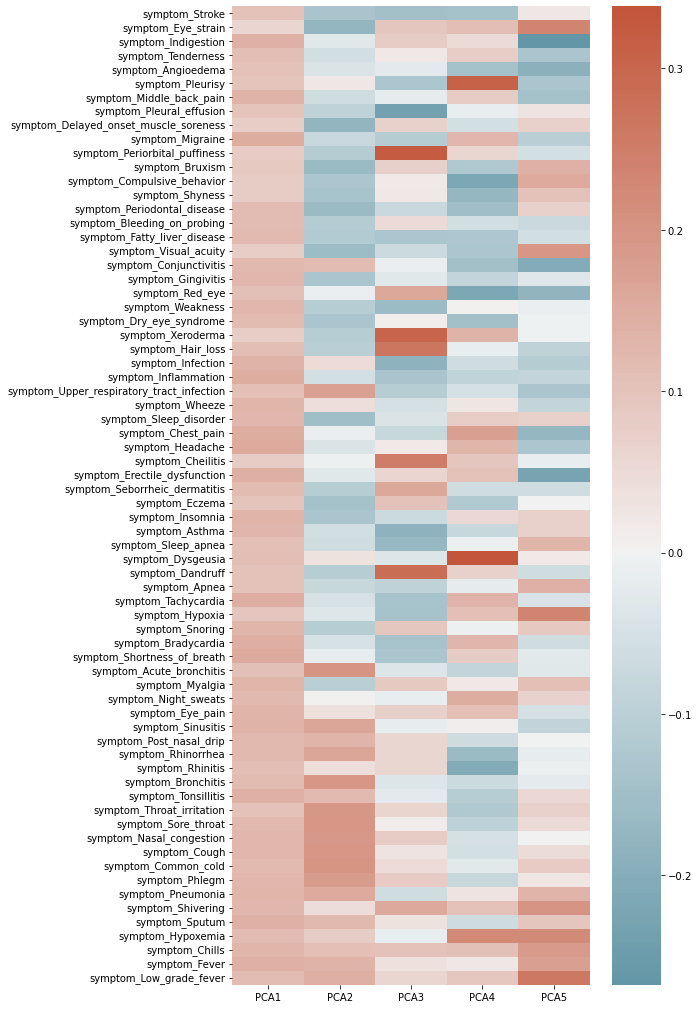

In [411]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)

PCA_comp_sub = PCA_comp[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5']]

fig, ax = plt.subplots(figsize = (8, 18))
g = sns.heatmap(PCA_comp_sub, center = 0, cmap=cmap)

From this chart, it appears as if PCA1 represents most of the general correlation between symptoms. Since PCA1 appears to correlate with cases, perhaps people are searching all sorts of symptoms when they get sick with COVID. Meanwhile, PCA5 appears to correlate more strongly with the specific symptoms of COVID-19 (fever, chills, hypoxemia, shivering, hypoxia), which explains why it also has a stronger correlation.

### Case Prediction using Multiple Linear Models (with Interaction)

Finally, let's see how well we can predict cases based on our given features.

In [442]:
df = pd.read_csv("symptoms_cases_day1_7_14_scaled3.csv", parse_dates=['date'])
df.head()

,date,state,cases_7ewm,day1_cases,day7_cases,day14_cases,cases,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,distributed_per_hundred,...,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30,cases_7ewm_inThousands
0,2021-01-12,Alabama,3848.000000,3497.0,2670.0,2766.0,3848,0.1500,1.590,7.69,...,-1.051108,0.049442,0.036445,-0.097427,0.222102,0.523276,-0.791568,0.258096,0.103992,3.848000
1,2021-01-13,Alabama,3497.500000,3527.0,2665.0,2775.0,3147,0.1900,1.710,7.73,...,0.429056,-0.629275,0.964807,0.045447,-0.661486,-0.071350,-0.569590,-0.162728,0.406475,3.497500
2,2021-01-14,Alabama,3527.666667,3382.0,2564.0,2885.0,3588,0.2350,1.880,8.88,...,-0.436407,-1.177230,0.018171,0.233678,-0.220097,0.040736,0.034506,0.068239,0.297959,3.527667
3,2021-01-15,Alabama,3382.000000,3336.0,2651.0,2785.0,2945,0.2800,2.050,9.07,...,0.125867,-0.227742,0.812035,0.230564,-0.779614,0.563964,-0.511651,0.470560,-0.216325,3.382000
4,2021-01-16,Alabama,3336.200000,3099.0,2680.0,2305.0,3153,0.2925,2.205,9.07,...,-0.109861,-1.694135,0.581554,0.551766,-0.000366,-0.485989,-0.807529,0.599322,-0.147424,3.336200


In [443]:
df.columns

Index(['date', 'state', 'cases_7ewm', 'day1_cases', 'day7_cases',
       'day14_cases', 'cases', 'people_fully_vaccinated_per_hundred',
       'total_vaccinations_per_hundred', 'distributed_per_hundred', 'deaths',
       'total_distributed', 'PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6',
       'PCA7', 'PCA8', 'PCA9', 'PCA10', 'PCA11', 'PCA12', 'PCA13', 'PCA14',
       'PCA15', 'PCA16', 'PCA17', 'PCA18', 'PCA19', 'PCA20', 'PCA21', 'PCA22',
       'PCA23', 'PCA24', 'PCA25', 'PCA26', 'PCA27', 'PCA28', 'PCA29', 'PCA30',
       'cases_7ewm_inThousands'],
      dtype='object')

Let's remove some features that I don't intend to use, since they don't appear to strongly correlate with cases.

In [444]:
df = df.drop(['cases_7ewm', 'cases', 'people_fully_vaccinated_per_hundred',
             'total_vaccinations_per_hundred', 'deaths', 'distributed_per_hundred'],
             axis=1)
df = df.set_index(['date', 'day1_cases', 'day7_cases', 'day14_cases', 'cases_7ewm_inThousands']).reset_index()
df

,date,day1_cases,day7_cases,day14_cases,cases_7ewm_inThousands,state,total_distributed,PCA1,PCA2,PCA3,...,PCA21,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30
0,2021-01-12,3497.0,2670.0,2766.0,3.848000,Alabama,377025.0,4.214105,-1.360864,-1.122342,...,-0.001299,-1.051108,0.049442,0.036445,-0.097427,0.222102,0.523276,-0.791568,0.258096,0.103992
1,2021-01-13,3527.0,2665.0,2775.0,3.497500,Alabama,378975.0,5.076046,-1.895773,-0.874276,...,0.010227,0.429056,-0.629275,0.964807,0.045447,-0.661486,-0.071350,-0.569590,-0.162728,0.406475
2,2021-01-14,3382.0,2564.0,2885.0,3.527667,Alabama,435350.0,5.781980,-3.079688,-0.897998,...,0.276096,-0.436407,-1.177230,0.018171,0.233678,-0.220097,0.040736,0.034506,0.068239,0.297959
3,2021-01-15,3336.0,2651.0,2785.0,3.382000,Alabama,444650.0,3.070736,-1.068224,-0.583097,...,-0.709200,0.125867,-0.227742,0.812035,0.230564,-0.779614,0.563964,-0.511651,0.470560,-0.216325
4,2021-01-16,3099.0,2680.0,2305.0,3.336200,Alabama,444650.0,4.471371,-1.103577,2.817615,...,0.403009,-0.109861,-1.694135,0.581554,0.551766,-0.000366,-0.485989,-0.807529,0.599322,-0.147424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12175,2022-03-03,588.0,NaN,NaN,0.623714,Wisconsin,11106345.0,-1.254858,-0.930940,-0.954430,...,-0.960920,0.653898,0.061195,-0.087135,-0.099779,0.142119,-0.091319,0.049824,-0.114583,0.715042
12176,2022-03-04,588.0,NaN,NaN,0.588714,Wisconsin,11114045.0,-4.563885,1.089353,-1.053553,...,-1.089251,0.575490,0.340593,0.069552,-0.470579,0.070150,-0.816361,-0.323305,-0.027715,0.345261
12177,2022-03-05,588.0,NaN,NaN,0.588714,Wisconsin,11118845.0,-4.939448,2.057746,1.645799,...,-1.084505,-0.407090,0.864673,-0.521749,-0.127799,-0.057630,-0.094009,-0.475943,-0.008574,0.271340
12178,2022-03-06,530.0,NaN,NaN,0.588714,Wisconsin,11118845.0,-2.681390,0.834122,1.899669,...,-0.388543,0.611086,-0.523098,-0.233188,-0.220573,-0.121253,0.259027,-0.832088,-0.820063,0.051480


Given that there will be only p+1 weights in a simple linear model with p features, I don't see much purpose in performing a randomized train-test split on a simple linear regression. Instead, I am more interested in whether a model can generalize to new hypothetical data that may not necessarily follow the same data distribution as the training set I have here. In other words, I'd like to see whether my model, trained on a specific set of dates, can generalize to future dates. For this reason, I'm going to instead use earlier dates as my training set and hold out a test set from the later dates. 

In [445]:
test_startIndex = int(df.date.unique().shape[0] * 0.8)
test_dates = df['date'].unique()[test_startIndex: ]
train = df[~df['date'].isin(test_dates)]
test = df[df['date'].isin(test_dates)]
test

,date,day1_cases,day7_cases,day14_cases,cases_7ewm_inThousands,state,total_distributed,PCA1,PCA2,PCA3,...,PCA21,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30
336,2021-12-14,682.0,774.0,2097.0,0.688571,Alabama,8020150.0,4.757060,4.718684,-1.680172,...,-0.803337,-0.422168,-0.323850,-0.349508,0.587743,-1.049400,0.480263,0.039591,0.441352,-0.009210
337,2021-12-15,721.0,890.0,2742.0,0.682857,Alabama,8050350.0,4.208728,4.529358,-2.312175,...,-0.678996,-0.046158,0.312530,-0.853851,0.632087,-0.709121,0.008933,0.642503,0.837333,0.222329
338,2021-12-16,766.0,1068.0,3627.0,0.721000,Alabama,8069670.0,4.407939,5.128423,-1.854628,...,-0.458631,-0.099508,0.175455,-0.401875,0.157095,-0.002690,0.083925,0.355723,0.234577,0.225716
339,2021-12-17,763.0,1290.0,4425.0,0.766143,Alabama,8120290.0,1.974475,6.567007,-1.306286,...,-0.441852,-0.265031,0.173935,-1.213732,0.222237,-0.406037,-0.325383,1.209845,1.014501,0.078842
340,2021-12-18,794.0,1541.0,4075.0,0.763143,Alabama,8039060.0,2.871836,6.932511,0.664556,...,0.613510,-0.138502,-0.981572,-1.040049,-0.303553,-0.082623,-0.441914,1.097949,0.660871,0.905129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12175,2022-03-03,588.0,NaN,NaN,0.623714,Wisconsin,11106345.0,-1.254858,-0.930940,-0.954430,...,-0.960920,0.653898,0.061195,-0.087135,-0.099779,0.142119,-0.091319,0.049824,-0.114583,0.715042
12176,2022-03-04,588.0,NaN,NaN,0.588714,Wisconsin,11114045.0,-4.563885,1.089353,-1.053553,...,-1.089251,0.575490,0.340593,0.069552,-0.470579,0.070150,-0.816361,-0.323305,-0.027715,0.345261
12177,2022-03-05,588.0,NaN,NaN,0.588714,Wisconsin,11118845.0,-4.939448,2.057746,1.645799,...,-1.084505,-0.407090,0.864673,-0.521749,-0.127799,-0.057630,-0.094009,-0.475943,-0.008574,0.271340
12178,2022-03-06,530.0,NaN,NaN,0.588714,Wisconsin,11118845.0,-2.681390,0.834122,1.899669,...,-0.388543,0.611086,-0.523098,-0.233188,-0.220573,-0.121253,0.259027,-0.832088,-0.820063,0.051480


Now let's try a simple linear regression that tries to predict the cases 7 days in advance by only using the PCA axes. I'm going to use Patsy to set up a design matrix since sklearn doesn't seem to support interaction terms.

Text(0.2, 100000, 'R2 = 0.21092550599986237\nRMSE = 12695.231311210388')

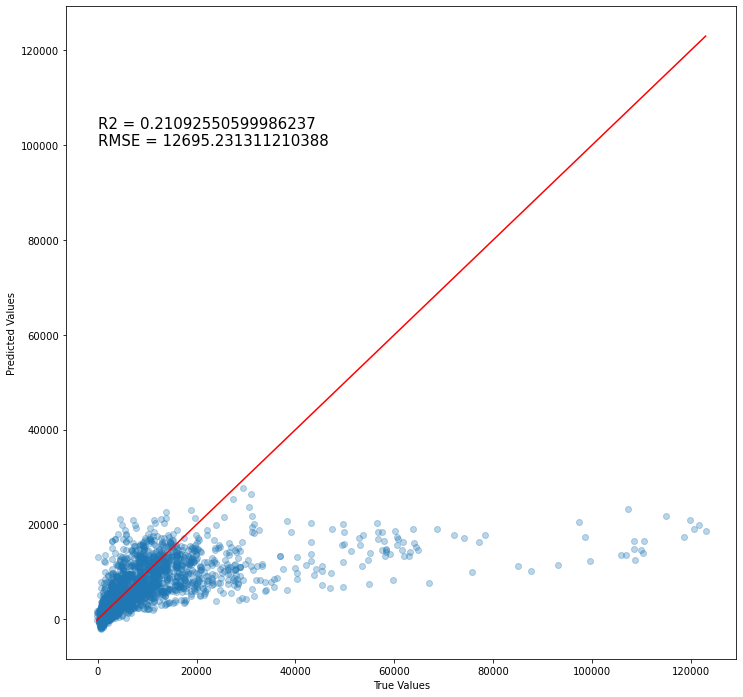

In [446]:
from patsy import dmatrices

PCAs = [i for i in train.columns if 'PCA' in i]
design = "day7_cases ~ " + " + ".join(PCAs)

y_train, X_train = dmatrices(design, train)
y_test, X_test = dmatrices(design, test)

mod = LinearRegression()
mod.fit(X_train, y_train)

y_test_pred = mod.predict(X_test)

shape = pd.DataFrame(X_test).shape
R2 = adjusted_R2(y_test, y_test_pred, shape)
RMSE = RMSE_val(y_test, y_test_pred)

fig, ax = graph_true_vs_predict(y_test, y_test_pred)

ax.text(x = 0.2, y = 100000, s = f'R2 = {R2}\nRMSE = {RMSE}', size=15)


Perhaps unsurprisingly, only 21% of variance in (smoothed) cases was explained by the PCA axes alone. This is probably because these axes are normal-scaled, which means that while the axes may correlate with the number of cases, there is no indication in the current data given the number of people in each state.

To create a stand-in for population size, let's add 'total_distributed' to the model. While the % vaccinated varies between states, the magnitude of variation (2-fold maxiumum) is dwarfed by the magnitude of variation in actual population size between states, so this decently represents the population size without giving any extra information on the number of cases.

Text(0.2, 100000, 'R2 = 0.30427385256400197\nRMSE = 11917.964776011468')

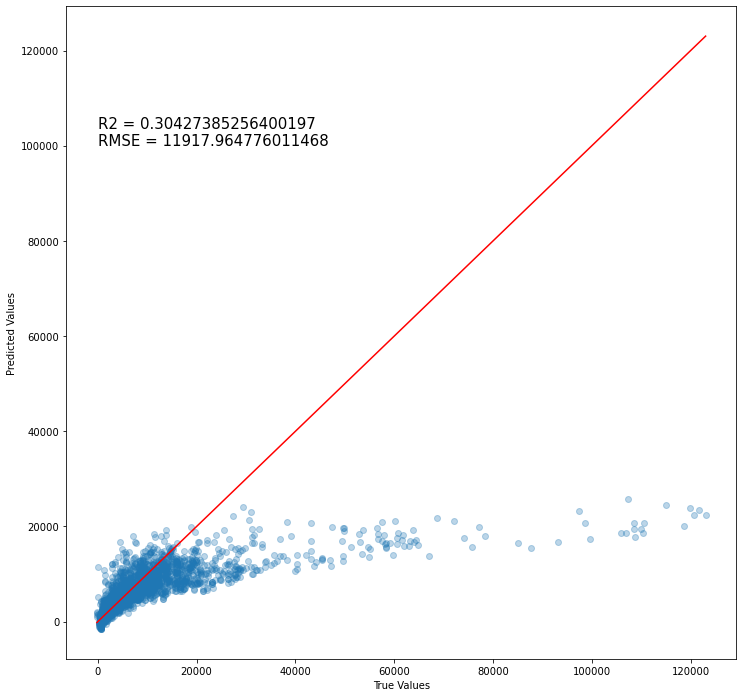

In [447]:
PCAs = [i for i in train.columns if 'PCA' in i]
design = "day7_cases ~ total_distributed + " + " + ".join(PCAs)

y_train, X_train = dmatrices(design, train)
y_test, X_test = dmatrices(design, test)

mod = LinearRegression()
mod.fit(X_train, y_train)

y_test_pred = mod.predict(X_test)

shape = pd.DataFrame(X_test).shape
R2 = adjusted_R2(y_test, y_test_pred, shape)
RMSE = RMSE_val(y_test, y_test_pred)

fig, ax = graph_true_vs_predict(y_test, y_test_pred)

ax.text(x = 0.2, y = 100000, s = f'R2 = {R2}\nRMSE = {RMSE}', size=15)

Luckily, simply putting an imperfect stand-in for population already increased the accounted variance by about 9%. Now, let's try predict next week's cases with search trends and today's cases.

Text(0.2, 120000, 'R2 = 0.8017431203024068\nRMSE = 6362.049854086317')

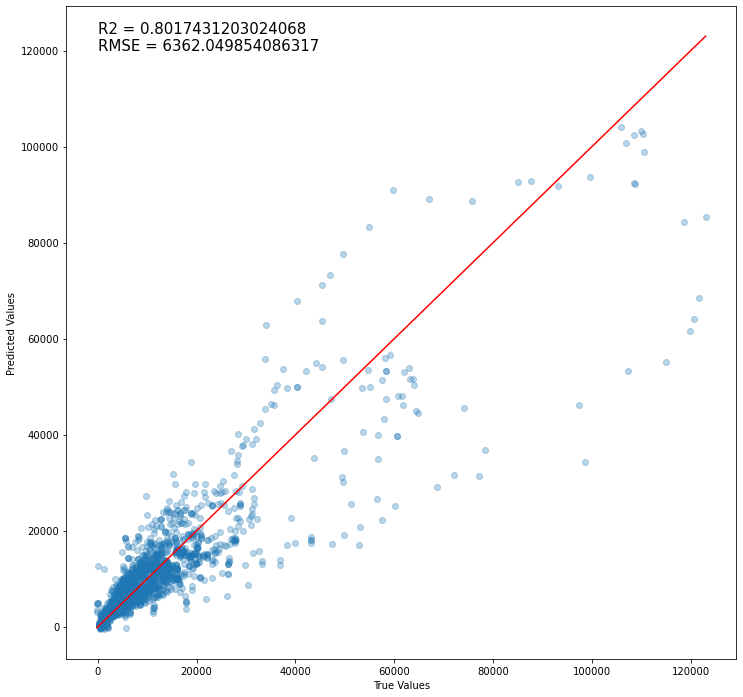

In [448]:
PCAs = [i for i in PCA_df.columns if "PCA" in i]
design = "day7_cases ~ cases_7ewm_inThousands + " + " + ".join(PCAs)

y_train, X_train = dmatrices(design, train)
y_test, X_test = dmatrices(design, test)

mod = LinearRegression()
mod.fit(X_train, y_train)

y_test_pred = mod.predict(X_test)

shape = pd.DataFrame(X_test).shape
R2 = adjusted_R2(y_test, y_test_pred, shape)
RMSE = RMSE_val(y_test, y_test_pred)

fig, ax = graph_true_vs_predict(y_test, y_test_pred)

ax.text(x = 0.2, y = 120000, s = f'R2 = {R2}\nRMSE = {RMSE}', size=15)

Now this model is becoming more accurate. The model is less accurate at predicting case loads when true cases are very high -- this is unfortunate because these dates are probably the ones where accurate prediction is most important.

Since each PCA axis is representing relative variance of symptom searches, and symptom searches were originally reported as a percent of total searches in each state, I suspect that the effect of each PCA axis on the model should also depend on the number of people in each state -- for big states, a 1 std increase in PCA axis should correspond to a larger number of cases than a 1 std increase in a smaller state. To model this, let's add an interaction between each PCA and the number of daily cases.

Text(0.2, 100000, 'R2 = 0.7015367916527967\nRMSE = 7805.99621255409')

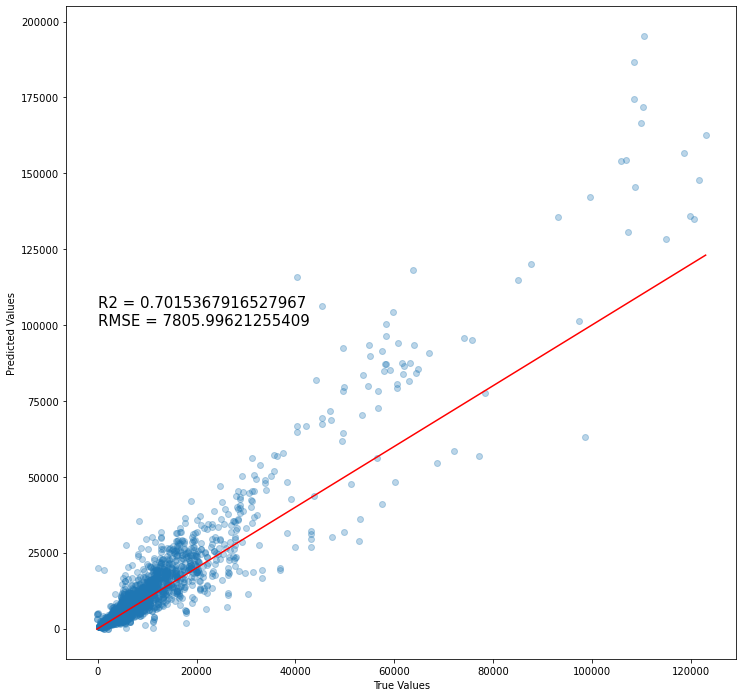

In [449]:
PCAs = [i + ":cases_7ewm_inThousands" for i in PCA_df.columns if "PCA" in i]
design = "day7_cases ~ cases_7ewm_inThousands + " + " + ".join(PCAs)

y_train, X_train = dmatrices(design, train)
y_test, X_test = dmatrices(design, test)

mod = LinearRegression()
mod.fit(X_train, y_train)

y_test_pred = mod.predict(X_test)

shape = pd.DataFrame(X_test).shape
R2 = adjusted_R2(y_test, y_test_pred, shape)
RMSE = RMSE_val(y_test, y_test_pred)

fig, ax = graph_true_vs_predict(y_test, y_test_pred)

ax.text(x = 0.2, y = 100000, s = f'R2 = {R2}\nRMSE = {RMSE}', size=15)

I'm surprised that this change didn't improve the model. Not surprisingly, it now appears to underpredict when cases are high, as opposed to the other model which tends to overpredict when cases are high. Perhaps the real interaction term between cases and symptom searches should be polynomial or logarithmic instead. Finally, let's try a full interaction term.

Text(0.2, 100000, 'R2 = 0.6568696287811364\nRMSE = 8312.488188760986')

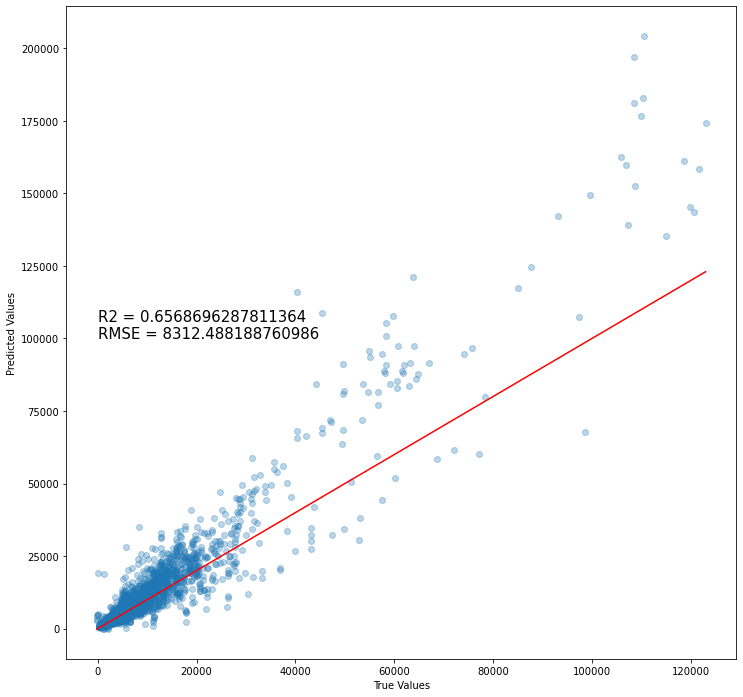

In [450]:
PCAs = [i + "*cases_7ewm_inThousands" for i in PCA_df.columns if "PCA" in i]
design = "day7_cases ~ cases_7ewm_inThousands + " + " + ".join(PCAs)

y_train, X_train = dmatrices(design, train)
y_test, X_test = dmatrices(design, test)

mod = LinearRegression()
mod.fit(X_train, y_train)

y_test_pred = mod.predict(X_test)

shape = pd.DataFrame(X_test).shape
R2 = adjusted_R2(y_test, y_test_pred, shape)
RMSE = RMSE_val(y_test, y_test_pred)

fig, ax = graph_true_vs_predict(y_test, y_test_pred)

ax.text(x = 0.2, y = 100000, s = f'R2 = {R2}\nRMSE = {RMSE}', size=15)

The adjusted R<sup>2</sup> decrease is marginal and probably a result of adding unnecessary features. These results suggest that the coefficients for the interaction terms do not generalize well to later dates. 

Do symptom trends even help the prediction? Let's review our best model and compare it against a model without symptom trends.

Text(0.2, 120000, 'R2 = 0.8017431203024068\nRMSE = 6362.049854086317')

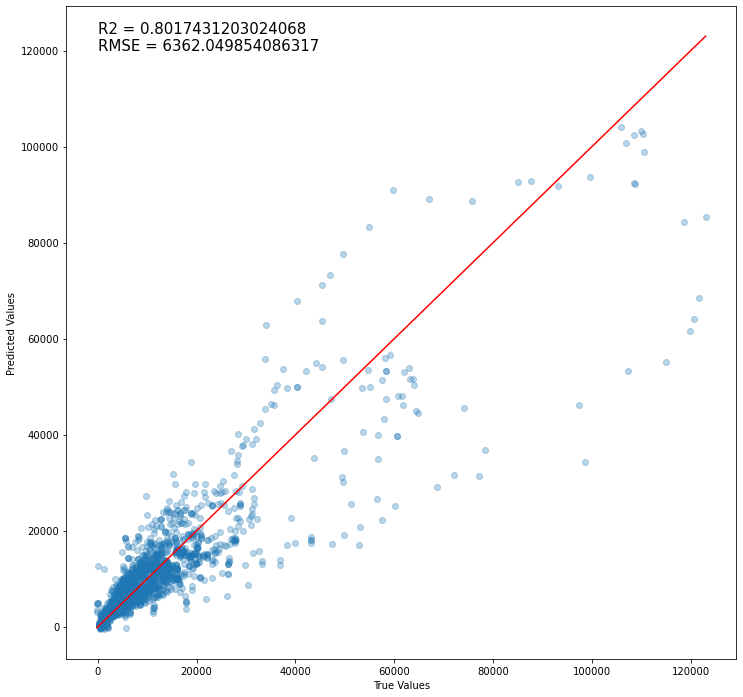

In [451]:
## Best model

PCAs = [i for i in PCA_df.columns if "PCA" in i]
design = "day7_cases ~ cases_7ewm_inThousands + " + " + ".join(PCAs)

y_train, X_train = dmatrices(design, train)
y_test, X_test = dmatrices(design, test)

mod = LinearRegression()
mod.fit(X_train, y_train)

y_test_pred = mod.predict(X_test)

shape = pd.DataFrame(X_test).shape
R2 = adjusted_R2(y_test, y_test_pred, shape)
RMSE = RMSE_val(y_test, y_test_pred)

fig, ax = graph_true_vs_predict(y_test, y_test_pred)

ax.text(x = 0.2, y = 120000, s = f'R2 = {R2}\nRMSE = {RMSE}', size=15)

Text(0.2, 120000, 'R2 = 0.7536548883851205\nRMSE = 7139.963639468081')

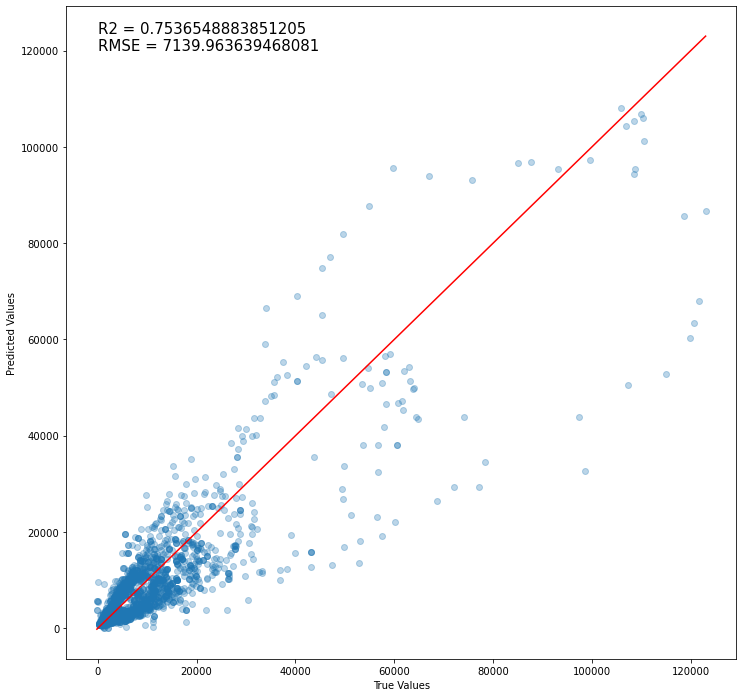

In [452]:
## "Null" model

design = "day7_cases ~ cases_7ewm_inThousands"

y_train, X_train = dmatrices(design, train)
y_test, X_test = dmatrices(design, test)

null_mod = LinearRegression()
null_mod.fit(X_train, y_train)

y_test_pred = null_mod.predict(X_test)

shape = pd.DataFrame(X_test).shape
R2 = adjusted_R2(y_test, y_test_pred, shape)
RMSE = RMSE_val(y_test, y_test_pred)

fig, ax = graph_true_vs_predict(y_test, y_test_pred)

ax.text(x = 0.2, y = 120000, s = f'R2 = {R2}\nRMSE = {RMSE}', size=15)

Well, it appears as if the symptoms marginally help, but not by much.

## Predicting Cases after 2 Weeks

What about cases after two weeks? Any local policy change related to covid will need at least this much time to implement, so let's see how well these features can predict cases two weeks in advance.

### Initial Modelling of Cases after 2 Weeks

Text(0.2, 120000, 'R2 = 0.4702243523498538\nRMSE = 10782.3416517526')

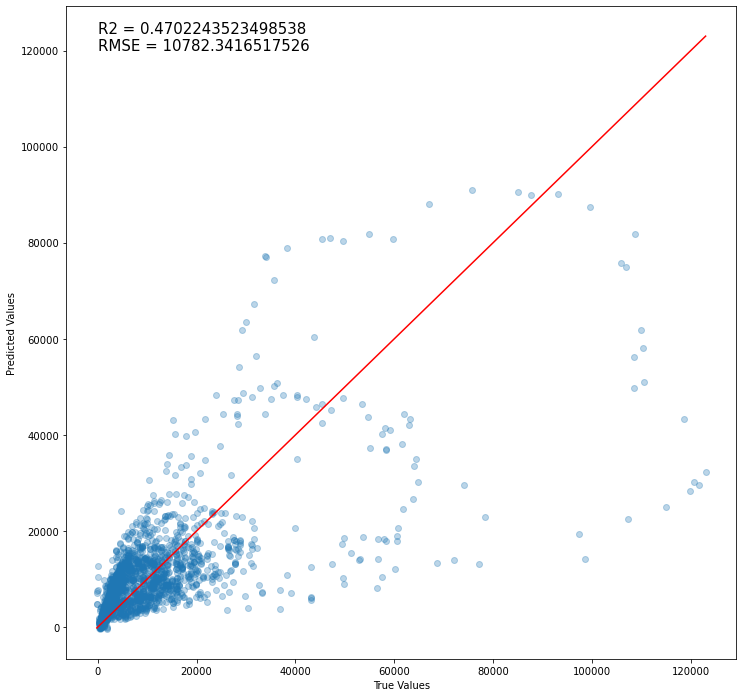

In [453]:
PCAs = [i for i in PCA_df.columns if "PCA" in i]
design = "day14_cases ~ cases_7ewm_inThousands + " + " + ".join(PCAs)

y_train, X_train = dmatrices(design, train)
y_test, X_test = dmatrices(design, test)

mod = LinearRegression()
mod.fit(X_train, y_train)

y_test_pred = mod.predict(X_test)

shape = pd.DataFrame(X_test).shape
R2 = adjusted_R2(y_test, y_test_pred, shape)
RMSE = RMSE_val(y_test, y_test_pred)

fig, ax = graph_true_vs_predict(y_test, y_test_pred)

ax.text(x = 0.2, y = 120000, s = f'R2 = {R2}\nRMSE = {RMSE}', size=15)

Let's take a look at which coefficients are most contributing to the model.

In [454]:
coef = pd.DataFrame(mod.coef_)
cols = ['intercept', 'cases_7ewm_inThousands']
cols.extend(PCAs)
coef.columns = cols
coef = coef.T

coef.columns = ['coef']
keep_coef = coef[coef['coef'].abs() > 200]

cols = keep_coef.index
cols

Index(['cases_7ewm_inThousands', 'PCA2', 'PCA5', 'PCA6', 'PCA7', 'PCA10',
       'PCA14', 'PCA19'],
      dtype='object')

In [455]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

Let's keep these features which contribute strongly to our model. Then, we'll engineer some features from these PCAs to represent their trends over time.

### Engineering Trend Features

In [509]:
keep_cols = ['state', 'day1_cases', 'day7_cases', 'day14_cases', 'date']
cols = ['cases_7ewm_inThousands', 'PCA2', 'PCA5',
                  'PCA6', 'PCA7', 'PCA10', 'PCA14', 'PCA19']
keep_cols.extend(cols)

df = df[keep_cols]
df = df.reset_index()

In [514]:
def calc_trends(df, col):
    """
    Input: df and column name
    Output: 3- and 7-day trend of given column per day/state, returned as a dataframe.
    """
    length = df.shape[0]
    
    total_vals = []
    
    for i in range(0, length):
        state = df.loc[i]['state']
        date = str(df.loc[i]['date'])
        
        prev_dates = [str((pd.to_datetime(date) - timedelta(days=i)).date()) for i in range(1,8)]
        
        date_vals = []
            
        current_val = find_line(df, state, date)[col].values[0]
        
        col_vals = [current_val]
        
        for dt in prev_dates:
            
            try:
                dt_val = find_line(df, state, dt)[col].values[0]
            except IndexError:
                dt_val=None
            
            col_vals.append(dt_val)
             
        col_vals = [i for i in col_vals if not i is None]
        index_vals = np.asarray([-i for i in range(0, len(col_vals))]).reshape(-1,1)
        
        if len(col_vals) >= 4:
            val_subset = col_vals[:4]
            ind_subset = index_vals[:4]
            reg = LinearRegression().fit(ind_subset, val_subset)
            coef = reg.coef_[0]
            date_vals.append(coef)
        else:
            date_vals.append(None)
            
        if len(col_vals) >= 8:
            val_subset = col_vals[:8]
            ind_subset = index_vals[:8]
            reg = LinearRegression().fit(ind_subset, val_subset)
            coef = reg.coef_[0]
            date_vals.append(coef)
        else:
            date_vals.append(None)
            
        
        total_vals.append(date_vals)
    
    total_vals = pd.DataFrame(total_vals)
    colnames = [col + "_" + str(i) + "dayTrend" for i in [3,7]]
    total_vals.columns = colnames
    
    return total_vals
        
        
def find_line(df, state, date):
    d1_val = df[(df['date'] == date) & (df['state'] == state)]
    return d1_val

In [516]:
for col in cols:
    newcols_df = calc_trends(df, col)
    df = df.merge(newcols_df, how='left',
                        left_index=True, right_index=True)

df.head()

dt = 2021-01-11, state = Alabama
dt = 2021-01-10, state = Alabama
dt = 2021-01-09, state = Alabama
dt = 2021-01-08, state = Alabama
dt = 2021-01-07, state = Alabama
dt = 2021-01-06, state = Alabama
dt = 2021-01-05, state = Alabama
dt = 2021-01-11, state = Alabama
dt = 2021-01-10, state = Alabama
dt = 2021-01-09, state = Alabama
dt = 2021-01-08, state = Alabama
dt = 2021-01-07, state = Alabama
dt = 2021-01-06, state = Alabama
dt = 2021-01-11, state = Alabama
dt = 2021-01-10, state = Alabama
dt = 2021-01-09, state = Alabama
dt = 2021-01-08, state = Alabama
dt = 2021-01-07, state = Alabama
dt = 2021-01-11, state = Alabama
dt = 2021-01-10, state = Alabama
dt = 2021-01-09, state = Alabama
dt = 2021-01-08, state = Alabama
dt = 2021-01-11, state = Alabama
dt = 2021-01-10, state = Alabama
dt = 2021-01-09, state = Alabama
dt = 2021-01-11, state = Alabama
dt = 2021-01-10, state = Alabama
dt = 2021-01-11, state = Alabama
dt = 2021-01-11, state = Arizona
dt = 2021-01-10, state = Arizona
dt = 2021-

,index,state,day1_cases,day7_cases,day14_cases,date,cases_7ewm_inThousands,PCA2,PCA5,PCA6,...,PCA6_3dayTrend,PCA6_7dayTrend,PCA7_3dayTrend,PCA7_7dayTrend,PCA10_3dayTrend,PCA10_7dayTrend,PCA14_3dayTrend,PCA14_7dayTrend,PCA19_3dayTrend,PCA19_7dayTrend
0,0,Alabama,3497.0,2670.0,2766.0,2021-01-12,3.848000,-1.360864,1.026581,-0.577873,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Alabama,3527.0,2665.0,2775.0,2021-01-13,3.497500,-1.895773,0.232553,-1.538478,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Alabama,3382.0,2564.0,2885.0,2021-01-14,3.527667,-3.079688,0.160645,-0.196252,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Alabama,3336.0,2651.0,2785.0,2021-01-15,3.382000,-1.068224,-0.314948,-0.977079,...,0.014461,NaN,-0.456696,NaN,0.053881,NaN,-0.138720,NaN,-0.306235,NaN
4,4,Alabama,3099.0,2680.0,2305.0,2021-01-16,3.336200,-1.103577,-1.742960,-1.055285,...,0.066875,NaN,-0.073842,NaN,0.150220,NaN,-0.087947,NaN,0.220271,NaN


In [517]:
df.to_csv("symptoms_cases_engineered_trends.csv", index=False)

### Modelling with Trends

Now that we've engineered short- and long-term trends in our features, let's see how much our symptoms help with the prediction. We'll first start with the model only containing past information about cases.

In [518]:
df = pd.read_csv("symptoms_cases_engineered_trends.csv", parse_dates=['date'])

In [521]:
test_startIndex = int(df.date.unique().shape[0] * 0.8)
test_dates = df['date'].unique()[test_startIndex: ]
train = df[~df['date'].isin(test_dates)]
test = df[df['date'].isin(test_dates)]
test.head()

,index,state,day1_cases,day7_cases,day14_cases,date,cases_7ewm_inThousands,PCA2,PCA5,PCA6,...,PCA6_3dayTrend,PCA6_7dayTrend,PCA7_3dayTrend,PCA7_7dayTrend,PCA10_3dayTrend,PCA10_7dayTrend,PCA14_3dayTrend,PCA14_7dayTrend,PCA19_3dayTrend,PCA19_7dayTrend
336,336,Alabama,682.0,774.0,2097.0,2021-12-14,0.688571,4.718684,-2.012721,-2.482995,...,-0.646824,0.017803,0.079319,-0.045229,-0.431645,-0.168917,-0.544254,-0.074036,-0.212249,0.022075
337,337,Alabama,721.0,890.0,2742.0,2021-12-15,0.682857,4.529358,-1.200331,-2.351848,...,-0.272631,-0.121485,0.159250,-0.059129,-0.377713,-0.100257,-0.147982,-0.057002,-0.064929,-0.026935
338,338,Alabama,766.0,1068.0,3627.0,2021-12-16,0.721000,5.128423,-1.039048,-1.092912,...,0.325331,-0.035300,-0.071009,-0.009815,0.190945,-0.033612,0.215226,-0.019557,-0.121181,-0.034042
339,339,Alabama,763.0,1290.0,4425.0,2021-12-17,0.766143,6.567007,-2.235421,-1.173697,...,0.518683,-0.027299,0.005529,-0.005497,0.463917,-0.020586,0.184943,-0.014351,0.364224,-0.002932
340,340,Alabama,794.0,1541.0,4075.0,2021-12-18,0.763143,6.932511,-3.175314,-0.200063,...,0.637457,0.088215,0.170212,0.090152,0.361383,0.057019,0.103288,-0.070138,0.339752,0.079117


Text(0.2, 120000, 'R2 = 0.46355697197110957\nRMSE = 10925.778136680427')

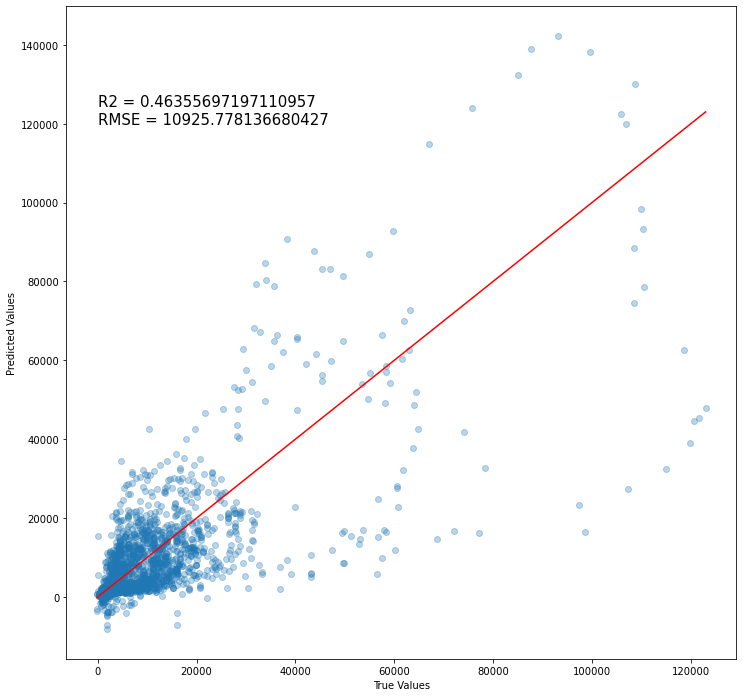

In [522]:
cols = [i for i in train.columns if "cases_7ewm_inThousands" in i]
design = "day14_cases ~ cases_7ewm_inThousands + " + " + ".join(cols)

y_train, X_train = dmatrices(design, train)
y_test, X_test = dmatrices(design, test)

mod = LinearRegression()
mod.fit(X_train, y_train)

y_test_pred = mod.predict(X_test)

shape = pd.DataFrame(X_test).shape
R2 = adjusted_R2(y_test, y_test_pred, shape)
RMSE = RMSE_val(y_test, y_test_pred)

fig, ax = graph_true_vs_predict(y_test, y_test_pred)

ax.text(x = 0.2, y = 120000, s = f'R2 = {R2}\nRMSE = {RMSE}', size=15)

Next, let's see how the linear addition of symptoms helps in model prediction.

Text(0.2, 120000, 'R2 = 0.4897962206680081\nRMSE = 10599.826461924944')

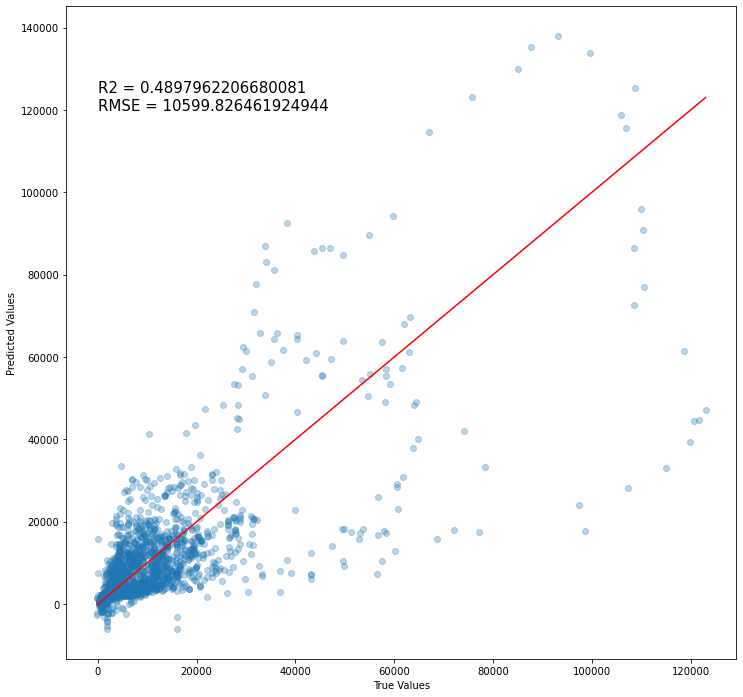

In [523]:
cols = [i for i in train.columns if "PCA" in i or "cases_7ewm_inThousands" in i]
design = "day14_cases ~ cases_7ewm_inThousands + " + " + ".join(cols)

y_train, X_train = dmatrices(design, train)
y_test, X_test = dmatrices(design, test)

mod = LinearRegression()
mod.fit(X_train, y_train)

y_test_pred = mod.predict(X_test)

shape = pd.DataFrame(X_test).shape
R2 = adjusted_R2(y_test, y_test_pred, shape)
RMSE = RMSE_val(y_test, y_test_pred)

fig, ax = graph_true_vs_predict(y_test, y_test_pred)

ax.text(x = 0.2, y = 120000, s = f'R2 = {R2}\nRMSE = {RMSE}', size=15)

The symptoms don't appear to help much at this point.

Finally, now that we have features that represent trends, I suspect that these trends are related to future cases depending on the current number of cases. So, let's turn these trends to interaction effects. (To prevent overfitting which happened last time, I am only including the interaction ':', not all individual constituents of an interaction '*')

''

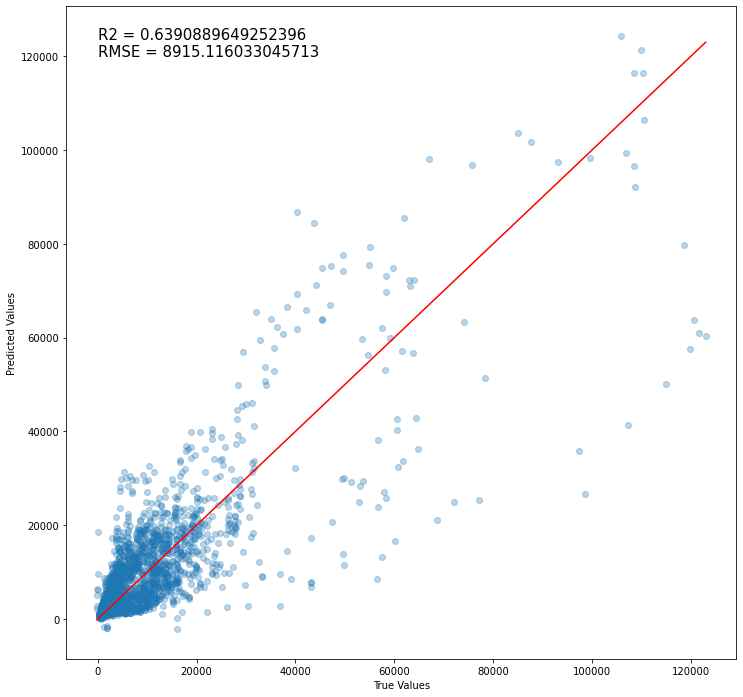

In [524]:
PCAs = [i + ":cases_7ewm_inThousands" for i in train.columns if "PCA" in i]
cases = [i for i in train.columns if "cases_7ewm_inThousands" in i]

design = "day14_cases ~ " + " + ".join(cases) + " + " + " + ".join(PCAs)

y_train, X_train = dmatrices(design, train)
y_test, X_test = dmatrices(design, test)

mod = LinearRegression()
mod.fit(X_train, y_train)

y_test_pred = mod.predict(X_test)

shape = pd.DataFrame(X_test).shape
R2 = adjusted_R2(y_test, y_test_pred, shape)
RMSE = RMSE_val(y_test, y_test_pred)

fig, ax = graph_true_vs_predict(y_test, y_test_pred)

ax.text(x = 0.2, y = 120000, s = f'R2 = {R2}\nRMSE = {RMSE}', size=15)
;

In [525]:
### final linear model formula
design

'day14_cases ~ cases_7ewm_inThousands + cases_7ewm_inThousands_3dayTrend + cases_7ewm_inThousands_7dayTrend + PCA2:cases_7ewm_inThousands + PCA5:cases_7ewm_inThousands + PCA6:cases_7ewm_inThousands + PCA7:cases_7ewm_inThousands + PCA10:cases_7ewm_inThousands + PCA14:cases_7ewm_inThousands + PCA19:cases_7ewm_inThousands + PCA2_3dayTrend:cases_7ewm_inThousands + PCA2_7dayTrend:cases_7ewm_inThousands + PCA5_3dayTrend:cases_7ewm_inThousands + PCA5_7dayTrend:cases_7ewm_inThousands + PCA6_3dayTrend:cases_7ewm_inThousands + PCA6_7dayTrend:cases_7ewm_inThousands + PCA7_3dayTrend:cases_7ewm_inThousands + PCA7_7dayTrend:cases_7ewm_inThousands + PCA10_3dayTrend:cases_7ewm_inThousands + PCA10_7dayTrend:cases_7ewm_inThousands + PCA14_3dayTrend:cases_7ewm_inThousands + PCA14_7dayTrend:cases_7ewm_inThousands + PCA19_3dayTrend:cases_7ewm_inThousands + PCA19_7dayTrend:cases_7ewm_inThousands'

In [526]:
columns = ['intercept'] + cases + PCAs
coef = pd.DataFrame(mod.coef_.T, index = columns)
coef.columns = ['coef']
coef

,coef
intercept,0.000000
cases_7ewm_inThousands,1074.676993
cases_7ewm_inThousands_3dayTrend,-229.323658
cases_7ewm_inThousands_7dayTrend,2125.896002
PCA2:cases_7ewm_inThousands,23.951101
PCA5:cases_7ewm_inThousands,-30.686869
PCA6:cases_7ewm_inThousands,27.439805
PCA7:cases_7ewm_inThousands,138.363866
PCA10:cases_7ewm_inThousands,-86.997451
PCA14:cases_7ewm_inThousands,-55.970705


An RMSE of 8915 is still not great as a predictor of COVID cases, but it shows that data of symptom searches and their derived features can be useful to augment the prediction of cases. Perhaps this information can be combined with other longitudinal features to create an accurate prediction of COVID cases in the future.

Permutation explainer: 2031it [00:37, 37.25it/s]                                                                                                                    


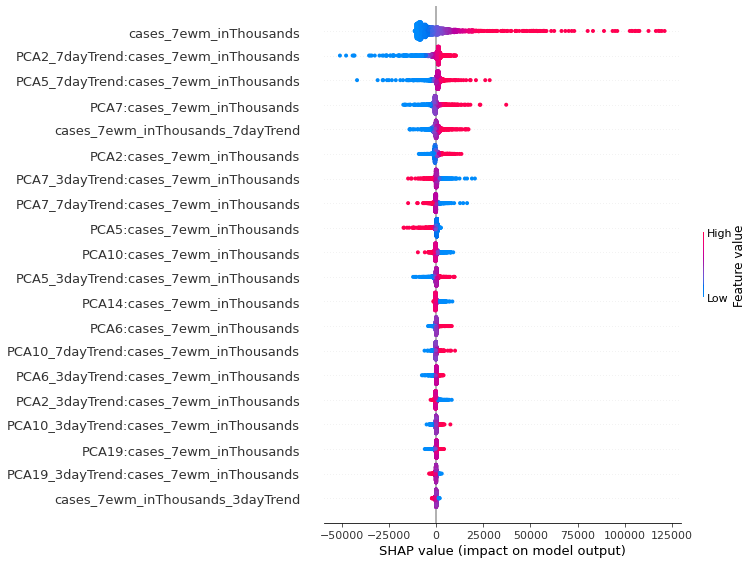

In [527]:
features = X_train.design_info.column_names
explainer = Explainer(mod.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names = features)

Finally, we can see that "today's cases" had the highest impact on our prediction, followed by many PCA dimensions/trends interacting with the current day's cases.

## Citations

McDonald, Daniel et al., 2021 (https://www.pnas.org/doi/10.1073/pnas.2111453118)

Barcellos, Demian et al., 2021 (https://www.nature.com/articles/s41598-021-04029-6#change-history)

COVID-19 ForecastHub (https://covid19forecasthub.org/reports/single_page.html)